In [1]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 2.2MB/s 


In [2]:
from pyunpack import Archive

In [3]:
Archive('/content/drive/My Drive/Colab Notebooks/data_Q3_2019.zip').extractall('/content')

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from math import log

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# DATA INFORMATION:



> The dataset is available publicly for the users from https://www.backblaze.com/b2/hard-drive-test-data.html#how-you-can-use-the-data


> The first row of the each file contains the column names, the remaining rows are the actual data. The columns are as follows:

##### Date – The date of the file in yyyy-mm-dd format.
##### Serial Number – The manufacturer-assigned serial number of the drive.
##### Model – The manufacturer-assigned model number of the drive.
##### Capacity – The drive capacity in bytes.
##### Failure – Contains a “0” if the drive is OK. Contains a “1” if the drive is failed.
##### S.M.A.R.T Attributes - Raw and Normalized.

> In this dataset SMART attributes have two variants namely raw value often corresponds to counts or a physical unit, such as degrees Celsius or seconds and normalized value which ranges from 1 to 253 (1 as worst case and 253 as best case).









# ML PROBLEM FORMULATION:

> It is the Binary class classification problem where we have to predict Hard Drive failure. These are predicted by using attributes that are recorded during normal operations of hard drive. These attributes are known as SMART(Self – Monitoring and Reporting Technology) which is the monitoring system included in computer HDD.

> The motive of this prediction is to reduce the rate of failures as a cost saving measure by the HDD vendors and software running on the host system may notify the user so preventive action can be taken to prevent data loss and failing drive can be replaced and data integrity is maintained.

> The HDD is said to be failed or critical when some of these attributes crosses the threshold values. Depending upon the manufacturers they use different SMART attributes in which the common attributes are like Read Error Rate, Throughput Performance, Spin-Up Time etc.

> References:
###### https://en.wikipedia.org/wiki/S.M.A.R.T
###### https://www.backblaze.com/b2/hard-drive-test-data.html#how-you-can-use-the-data









# PERFORMANCE METRICS:


1.   PRECISION, RECALL SCORES
2.   AUC SCORE AND CONFUSION MATRIX



# Importing Data




In [5]:
# Using 5 days of Data for Train and Val.
dates = ['02', '03', '04', '05']
Data = pd.read_csv("/content/data_Q3_2019/2019-07-01.csv")
for i in dates:
  Data = Data.append(pd.read_csv("/content/data_Q3_2019/2019-07-" + i + ".csv"))

In [6]:
print(Data.info())
print()
print("Shape of the Data: ", Data.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 553380 entries, 0 to 110699
Columns: 129 entries, date to smart_255_raw
dtypes: float64(124), int64(2), object(3)
memory usage: 548.9+ MB
None

Shape of the Data:  (553380, 129)


In [7]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized,...,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2019-07-01,Z305B2QN,ST4000DM000,4000787030016,0,119.0,224077128.0,NaN,NaN,91.0,0.0,100.0,13.0,100.0,0.0,87.0,531073315.0,NaN,NaN,65.0,31048.0,100.0,0.0,NaN,NaN,100.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,30796.0,100.0,4.863399e+10,100.0,1.425050e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-01,ZJV0XJQ4,ST12000NM0007,12000138625024,0,83.0,196781888.0,NaN,NaN,98.0,0.0,100.0,2.0,100.0,0.0,76.0,41279147.0,NaN,NaN,91.0,8097.0,100.0,0.0,NaN,NaN,100.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,7341.0,100.0,4.373717e+10,100.0,8.853983e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,76.0,37537312.0,NaN,NaN,99.0,0.0,100.0,1.0,100.0,0.0,88.0,570726398.0,NaN,NaN,95.0,5127.0,100.0,0.0,NaN,NaN,100.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,4786.0,100.0,3.967749e+10,100.0,2.115116e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-07-01,ZJV0XJQ0,ST12000NM0007,12000138625024,0,100.0,1592144.0,NaN,NaN,93.0,0.0,100.0,6.0,100.0,0.0,79.0,87683176.0,NaN,NaN,91.0,8692.0,100.0,0.0,NaN,NaN,100.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,8477.0,100.0,4.720428e+10,100.0,6.852008e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,436.0,100.0,9.0,100.0,0.0,100.0,0.0,113.0,42.0,97.0,21121.0,100.0,0.0,NaN,NaN,100.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
Data.tail()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized,...,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
110695,2019-07-05,ZA10MCEQ,ST8000DM002,8001563222016,0,83.0,210226056.0,NaN,NaN,94.0,0.0,100.0,3.0,100.0,0.0,94.0,2.702600e+09,NaN,NaN,70.0,26617.0,100.0,0.0,NaN,NaN,100.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,26605.0,100.0,7.121316e+10,100.0,1.331764e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110696,2019-07-05,ZCH0CRTK,ST12000NM0007,12000138625024,0,83.0,221616264.0,NaN,NaN,97.0,0.0,100.0,3.0,100.0,0.0,88.0,5.659543e+08,NaN,NaN,86.0,12268.0,100.0,0.0,NaN,NaN,100.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,12144.0,100.0,5.945845e+10,100.0,6.820471e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110697,2019-07-05,AAGA7W2H,HGST HUH721212ALN604,12000138625024,0,100.0,0.0,132.0,96.0,100.0,0.0,100.0,1.0,100.0,0.0,100.0,0.000000e+00,128.0,18.0,100.0,868.0,100.0,0.0,NaN,NaN,100.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110698,2019-07-05,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,0.0,100.0,4.0,100.0,0.0,100.0,0.000000e+00,113.0,42.0,98.0,20199.0,100.0,0.0,NaN,NaN,100.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110699,2019-07-05,PL2331LAHDS4TJ,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,133.0,104.0,100.0,439.0,100.0,6.0,100.0,0.0,100.0,0.000000e+00,113.0,42.0,98.0,20212.0,100.0,0.0,NaN,NaN,100.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
Data.reset_index(inplace = True)
Data['date'] = pd.to_datetime(Data['date'])
Data.columns

Index(['index', 'date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw',
       ...
       'smart_250_normalized', 'smart_250_raw', 'smart_251_normalized',
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw'],
      dtype='object', length=130)

From the above Dataset it is found that it many features contains NaN values.

# To Find the common features of all the models of HDD.







> Since each vendors provide different SMART attributes, I am finding and keeping the common attributes that each model have defined values.


> Attributes with many NaN are removed.

In [10]:
# Creating the copy of original data with removing the columns containing all instances as NaN.
Data.drop('index', axis = 1, inplace = True)
Test = Data.dropna(how = 'all', axis = 1)
Initial = Data.columns
Initial

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_250_normalized', 'smart_250_raw', 'smart_251_normalized',
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw'],
      dtype='object', length=129)

In [11]:
Test.shape # Shape of the data after removing the NaN Features.

(553380, 115)

In [12]:
# Critical Features for HDD failure as mentioned in Wikipedia and BlackBlaze.
# These features are removed to find other common features of all the models.
Features = ['5', '10', '184', '187', '188', '196', '197', '198']
len(Features)

8

In [13]:
for i in Features:
  features = ['smart_' + i + '_normalized', 'smart_' + i + '_raw']
  Test.drop(features, axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
# Shape of the data after removing the critical features.
Test.shape 

(553380, 99)

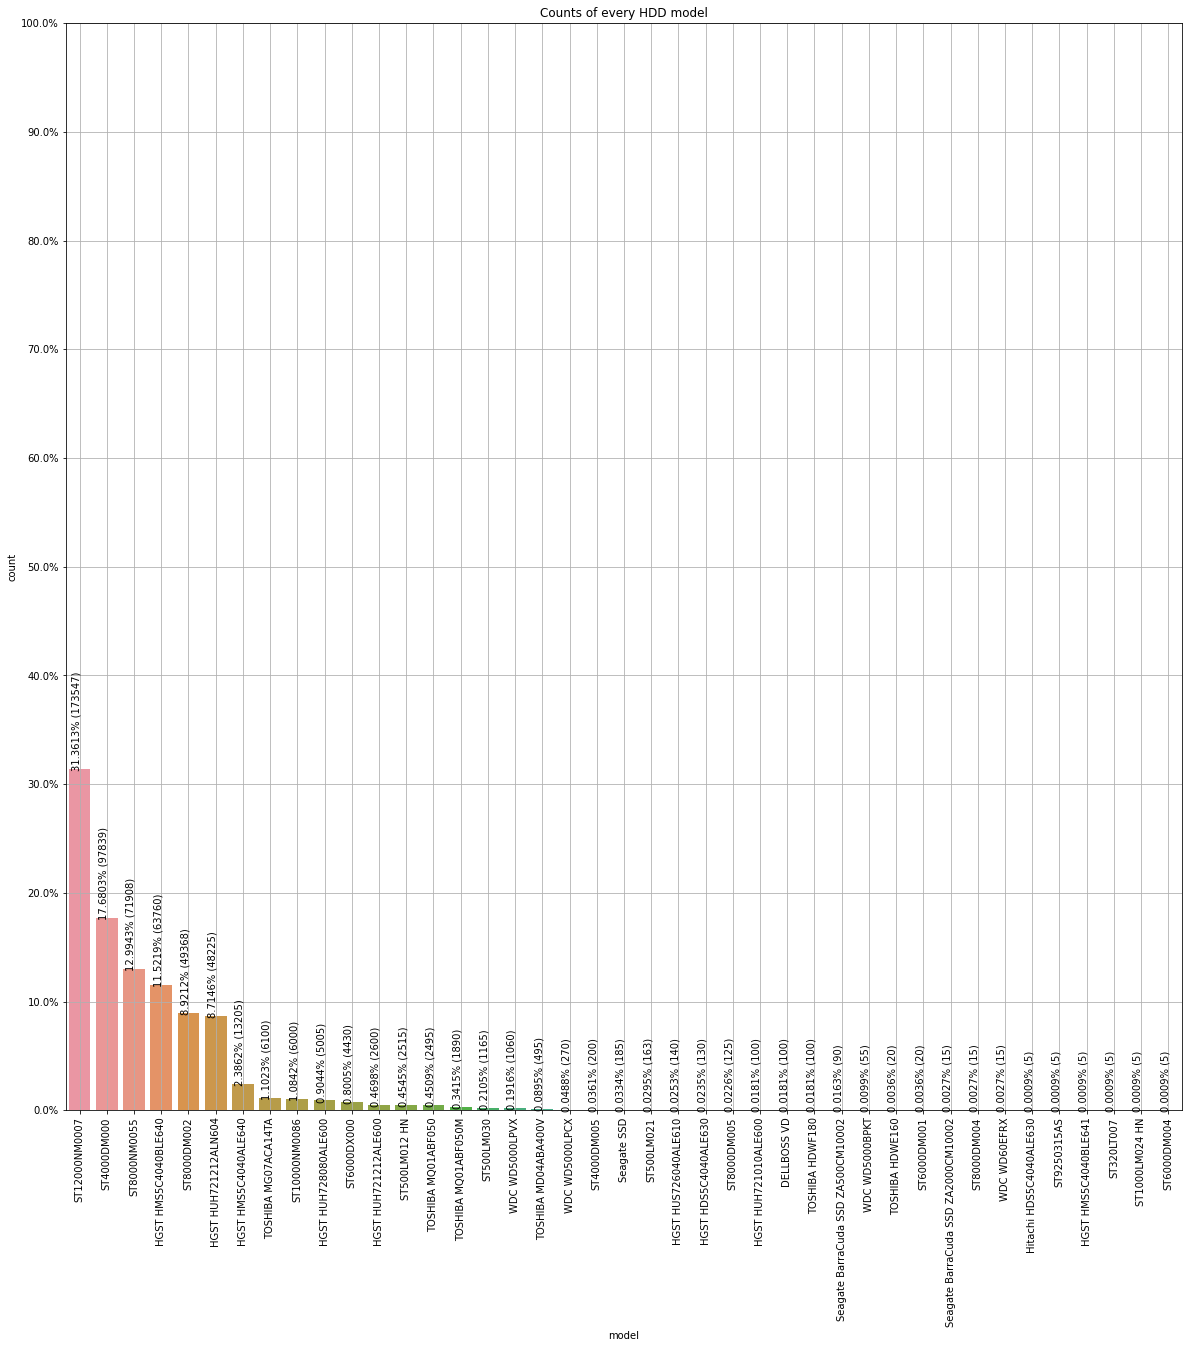

In [15]:
# Checking the count and percentage of unique models from the data.
total = len(Data)
plt.figure(figsize = (20,20))
ax = sns.countplot(x = "model", data = Test, order = Test.model.value_counts().index)
for p in ax.patches:
        ax.annotate('{:.4f}% ({})'.format(100*p.get_height()/total, p.get_height()), (p.get_x()+0.1, p.get_height()+5), rotation = 'vertical')

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.xticks(rotation=90)
plt.title('Counts of every HDD model')
plt.grid(True)
plt.show()

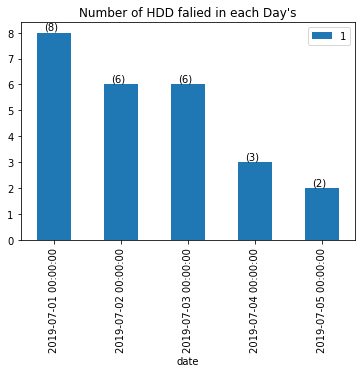

In [16]:
#This plot tells the number of HDD failed in each days
ax = Test.groupby(['date', 'failure'])['failure'].count().unstack(1)[1].plot.bar()
for p in ax.patches:
        ax.annotate('({})'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
plt.legend()
plt.title("Number of HDD falied in each Day's")
plt.show()

In [17]:
models = Test.model.value_counts().index
print("Number of Unique Models: ", len(models))
print(models)

Number of Unique Models:  41
Index(['ST12000NM0007', 'ST4000DM000', 'ST8000NM0055', 'HGST HMS5C4040BLE640',
       'ST8000DM002', 'HGST HUH721212ALN604', 'HGST HMS5C4040ALE640',
       'TOSHIBA MG07ACA14TA', 'ST10000NM0086', 'HGST HUH728080ALE600',
       'ST6000DX000', 'HGST HUH721212ALE600', 'ST500LM012 HN',
       'TOSHIBA MQ01ABF050', 'TOSHIBA MQ01ABF050M', 'ST500LM030',
       'WDC WD5000LPVX', 'TOSHIBA MD04ABA400V', 'WDC WD5000LPCX',
       'ST4000DM005', 'Seagate SSD', 'ST500LM021', 'HGST HUS726040ALE610',
       'HGST HDS5C4040ALE630', 'ST8000DM005', 'HGST HUH721010ALE600',
       'DELLBOSS VD', 'TOSHIBA HDWF180', 'Seagate BarraCuda SSD ZA500CM10002',
       'WDC WD5000BPKT', 'TOSHIBA HDWE160', 'ST6000DM001',
       'Seagate BarraCuda SSD ZA2000CM10002', 'ST8000DM004', 'WDC WD60EFRX',
       'Hitachi HDS5C4040ALE630', 'ST9250315AS', 'HGST HMS5C4040BLE641',
       'ST320LT007', 'ST1000LM024 HN', 'ST6000DM004'],
      dtype='object')


In [18]:
# Finding the failure rate of every model in 7 days.
for i in models:
  try:
    c = Test[Test.model == i].failure.value_counts()[1] / len(Test[Test.model == i]) * 100
    print(i, 'failure_rate is {:.5f} %'.format(c))
  except KeyError:
    print(i, 'failure_rate is 0 %')

ST12000NM0007 failure_rate is 0.00922 %
ST4000DM000 failure_rate is 0.00204 %
ST8000NM0055 failure_rate is 0.00417 %
HGST HMS5C4040BLE640 failure_rate is 0 %
ST8000DM002 failure_rate is 0.00405 %
HGST HUH721212ALN604 failure_rate is 0 %
HGST HMS5C4040ALE640 failure_rate is 0 %
TOSHIBA MG07ACA14TA failure_rate is 0 %
ST10000NM0086 failure_rate is 0.01667 %
HGST HUH728080ALE600 failure_rate is 0 %
ST6000DX000 failure_rate is 0 %
HGST HUH721212ALE600 failure_rate is 0 %
ST500LM012 HN failure_rate is 0 %
TOSHIBA MQ01ABF050 failure_rate is 0 %
TOSHIBA MQ01ABF050M failure_rate is 0 %
ST500LM030 failure_rate is 0.08584 %
WDC WD5000LPVX failure_rate is 0 %
TOSHIBA MD04ABA400V failure_rate is 0 %
WDC WD5000LPCX failure_rate is 0 %
ST4000DM005 failure_rate is 0 %
Seagate SSD failure_rate is 0 %
ST500LM021 failure_rate is 0 %
HGST HUS726040ALE610 failure_rate is 0 %
HGST HDS5C4040ALE630 failure_rate is 0 %
ST8000DM005 failure_rate is 0 %
HGST HUH721010ALE600 failure_rate is 0 %
DELLBOSS VD failur

From the above it is found that only five models have failed in these 7 days.

In [19]:
Test.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized,smart_24_raw,smart_168_normalized,smart_168_raw,smart_170_normalized,smart_170_raw,smart_173_normalized,smart_173_raw,smart_174_normalized,...,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw
0,2019-07-01,Z305B2QN,ST4000DM000,4000787030016,0,119.0,224077128.0,NaN,NaN,91.0,0.0,100.0,13.0,87.0,531073315.0,NaN,NaN,65.0,31048.0,NaN,NaN,100.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,30796.0,100.0,4.863399e+10,100.0,1.425050e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-01,ZJV0XJQ4,ST12000NM0007,12000138625024,0,83.0,196781888.0,NaN,NaN,98.0,0.0,100.0,2.0,76.0,41279147.0,NaN,NaN,91.0,8097.0,NaN,NaN,100.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.0,0.0,100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,7341.0,100.0,4.373717e+10,100.0,8.853983e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,76.0,37537312.0,NaN,NaN,99.0,0.0,100.0,1.0,88.0,570726398.0,NaN,NaN,95.0,5127.0,NaN,NaN,100.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.0,0.0,100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,4786.0,100.0,3.967749e+10,100.0,2.115116e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-07-01,ZJV0XJQ0,ST12000NM0007,12000138625024,0,100.0,1592144.0,NaN,NaN,93.0,0.0,100.0,6.0,79.0,87683176.0,NaN,NaN,91.0,8692.0,NaN,NaN,100.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.0,0.0,100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,8477.0,100.0,4.720428e+10,100.0,6.852008e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,436.0,100.0,9.0,100.0,0.0,113.0,42.0,97.0,21121.0,NaN,NaN,100.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Finding the features which has NaN percentage greater than 50%
M_features = Test.columns
print(Test.isnull().sum(axis = 0) / len(Test))
index = np.where(Test.isnull().sum(axis = 0) / len(Test) >= 0.5)[0]
len(index) # Count of the found features.

date                    0.000000
serial_number           0.000000
model                   0.000000
capacity_bytes          0.000000
failure                 0.000000
                          ...   
smart_251_raw           0.999991
smart_252_normalized    0.999991
smart_252_raw           0.999991
smart_254_normalized    0.997483
smart_254_raw           0.997483
Length: 99, dtype: float64


64

In [21]:
M_features[index]

Index(['smart_2_normalized', 'smart_2_raw', 'smart_8_normalized',
       'smart_8_raw', 'smart_11_normalized', 'smart_11_raw',
       'smart_16_normalized', 'smart_16_raw', 'smart_17_normalized',
       'smart_17_raw', 'smart_22_normalized', 'smart_22_raw',
       'smart_23_normalized', 'smart_23_raw', 'smart_24_normalized',
       'smart_24_raw', 'smart_168_normalized', 'smart_168_raw',
       'smart_170_normalized', 'smart_170_raw', 'smart_173_normalized',
       'smart_173_raw', 'smart_174_normalized', 'smart_174_raw',
       'smart_177_normalized', 'smart_177_raw', 'smart_183_normalized',
       'smart_183_raw', 'smart_189_normalized', 'smart_189_raw',
       'smart_191_normalized', 'smart_191_raw', 'smart_200_normalized',
       'smart_200_raw', 'smart_218_normalized', 'smart_218_raw',
       'smart_220_normalized', 'smart_220_raw', 'smart_222_normalized',
       'smart_222_raw', 'smart_223_normalized', 'smart_223_raw',
       'smart_224_normalized', 'smart_224_raw', 'smart_225_no

##### These are the attributes which have more than 50% of NaN.

# Relevant Features for Dataset

In [22]:
f = ['date',	'serial_number',	'model',	'capacity_bytes',	'failure']

In [23]:
Null = np.where(Data.isnull().sum(axis = 0) == len(Data))[0]
len(Initial[Null])

14

In [24]:
# Dropping the features with all instances as NaN from the original Dataset.
Data.dropna(how = 'all', axis = 1, inplace = True) 
print(Data.shape)
del Test # Removing the Test Dataframe to free the memory.

(553380, 115)


In [25]:
# Dropping the uncommon features found from above task from the original Dataset.
Data.drop(M_features[index], axis = 1, inplace = True)
Data.shape # Final shape of Data with relevant SMART attributes.

(553380, 51)

In [26]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,2019-07-01,Z305B2QN,ST4000DM000,4000787030016,0,119.0,224077128.0,91.0,0.0,100.0,13.0,100.0,0.0,87.0,531073315.0,65.0,31048.0,100.0,0.0,100.0,13.0,100.0,0.0,100.0,0.0,100.0,0.0,79.0,21.0,100.0,0.0,83.0,34185.0,21.0,21.0,NaN,NaN,NaN,NaN,100.0,0.0,100.0,0.0,200.0,0.0,100.0,30796.0,100.0,4.863399e+10,100.0,1.425050e+11
1,2019-07-01,ZJV0XJQ4,ST12000NM0007,12000138625024,0,83.0,196781888.0,98.0,0.0,100.0,2.0,100.0,0.0,76.0,41279147.0,91.0,8097.0,100.0,0.0,100.0,2.0,NaN,NaN,100.0,0.0,100.0,0.0,72.0,28.0,100.0,108.0,99.0,2329.0,28.0,28.0,83.0,196781888.0,NaN,NaN,100.0,0.0,100.0,0.0,200.0,0.0,100.0,7341.0,100.0,4.373717e+10,100.0,8.853983e+10
2,2019-07-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,76.0,37537312.0,99.0,0.0,100.0,1.0,100.0,0.0,88.0,570726398.0,95.0,5127.0,100.0,0.0,100.0,1.0,NaN,NaN,100.0,0.0,100.0,0.0,69.0,31.0,100.0,67.0,100.0,1783.0,31.0,31.0,76.0,37537312.0,NaN,NaN,100.0,0.0,100.0,0.0,200.0,0.0,100.0,4786.0,100.0,3.967749e+10,100.0,2.115116e+10
3,2019-07-01,ZJV0XJQ0,ST12000NM0007,12000138625024,0,100.0,1592144.0,93.0,0.0,100.0,6.0,100.0,0.0,79.0,87683176.0,91.0,8692.0,100.0,0.0,100.0,6.0,NaN,NaN,100.0,0.0,100.0,0.0,76.0,24.0,100.0,104.0,100.0,873.0,24.0,24.0,100.0,1592144.0,NaN,NaN,100.0,0.0,100.0,0.0,200.0,0.0,100.0,8477.0,100.0,4.720428e+10,100.0,6.852008e+10
4,2019-07-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,100.0,436.0,100.0,9.0,100.0,0.0,100.0,0.0,97.0,21121.0,100.0,0.0,100.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,340.0,100.0,340.0,193.0,31.0,NaN,NaN,100.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
Data.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
count,5.533800e+05,553380.000000,553223.000000,5.532230e+05,552933.000000,552933.000000,552933.000000,552933.000000,552933.000000,552933.000000,552933.000000,5.529330e+05,553223.000000,553223.000000,552933.000000,552933.000000,553223.0,553223.000000,231243.000000,231243.000000,404790.000000,404790.000000,404790.0,4.047900e+05,404790.000000,404790.000000,553223.000000,553223.000000,550413.000000,5.504130e+05,553223.000000,553223.000000,307948.000000,3.079480e+05,148143.000000,148143.000000,552933.000000,552933.000000,552933.000000,552933.000000,552933.000000,552933.000000,416255.000000,4.162550e+05,407730.000000,4.077300e+05,407730.000000,4.077300e+05
mean,8.286910e+12,0.000045,92.146747,8.918688e+07,96.788437,162.119016,99.998616,8.064454,100.942038,8.458112,91.582324,1.351338e+09,83.519644,18051.106402,100.685553,27.854243,100.0,5.923445,99.998205,0.001795,99.938583,0.089548,100.0,1.601030e+08,71.339453,28.660547,100.550248,202.791798,94.941148,1.230368e+04,74.508012,28.619011,64.486166,1.208195e+08,103.520247,0.399486,100.944563,0.070840,100.692742,0.064055,199.990957,0.291849,99.957524,3.637051e+09,100.013489,5.072083e+10,100.013489,1.145427e+11
std,3.603226e+12,0.006721,15.465778,8.105061e+07,10.439160,846.720294,0.118877,125.119764,11.392637,296.473022,13.970449,5.610513e+10,13.261720,10478.104180,10.241168,1920.638476,0.0,10.778789,0.172417,0.172417,1.033022,7.728807,0.0,4.043286e+09,6.675342,6.675342,8.995620,965.941410,13.217254,4.238828e+04,79.485973,6.238363,31.676831,7.126372e+07,21.805259,14.434013,11.380485,1.474285,10.238023,1.396831,0.950888,12.392017,1.451285,8.146078e+11,1.161358,1.206083e+10,1.161358,1.417538e+11
min,-1.000000e+00,0.000000,59.000000,0.000000e+00,79.000000,0.000000,75.000000,1.000000,56.000000,0.000000,55.000000,0.000000e+00,10.000000,0.000000,75.000000,0.000000,100.0,0.000000,81.000000,0.000000,1.000000,0.000000,100.0,0.000000e+00,45.000000,14.000000,81.000000,0.000000,1.000000,1.000000e+00,14.000000,12.000000,1.000000,0.000000e+00,37.000000,0.000000,100.000000,0.000000,100.000000,0.000000,100.000000,0.000000,26.000000,0.000000e+00,100.000000,0.000000e+00,100.000000,5.600000e+01
25%,4.000787e+12,0.000000,81.000000,0.000000e+00,92.000000,0.000000,100.000000,3.000000,100.000000,0.000000,87.000000,0.000000e+00,74.000000,10100.000000,100.000000,0.000000,100.0,3.000000,100.000000,0.000000,100.000000,0.000000,100.0,0.000000e+00,67.000000,23.000000,100.000000,1.000000,94.000000,4.400000e+02,25.000000,24.000000,72.000000,5.894246e+07,100.000000,0.000000,100.000000,0.000000,100.000000,0.000000,200.000000,0.000000,100.000000,1.068500e+04,100.000000,4.667963e+10,100.000000,9.366630e+10
50%,8.001563e+12,0.000000,84.000000,7.705140e+07,95.000000,0.000000,100.000000,5.000000,100.000000,0.000000,89.000000,4.450598e+08,85.000000,16818.000000,100.000000,0.000000,100.0,5.000000,100.000000,0.000000,100.000000,0.000000,100.0,0.000000e+00,72.000000,28.000000,100.000000,62.000000,100.000000,1.320000e+03,32.000000,28.000000,80.000000,1.208267e+08,100.000000,0.000000,100.000000,0.000000,100.000000,0.000000,200.000000,0.000000,100.000000,1.627500e+04,100.000000,5.158314e+10,100.000000,1.228817e+11
75%,1.200014e+13,0.000000,100.0000

In [28]:
RE = Data.columns 
RE

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_3_normalized',
       'smart_3_raw', 'smart_4_normalized', 'smart_4_raw',
       'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized',
       'smart_7_raw', 'smart_9_normalized', 'smart_9_raw',
       'smart_10_normalized', 'smart_10_raw', 'smart_12_normalized',
       'smart_12_raw', 'smart_184_normalized', 'smart_184_raw',
       'smart_187_normalized', 'smart_187_raw', 'smart_188_normalized',
       'smart_188_raw', 'smart_190_normalized', 'smart_190_raw',
       'smart_192_normalized', 'smart_192_raw', 'smart_193_normalized',
       'smart_193_raw', 'smart_194_normalized', 'smart_194_raw',
       'smart_195_normalized', 'smart_195_raw', 'smart_196_normalized',
       'smart_196_raw', 'smart_197_normalized', 'smart_197_raw',
       'smart_198_normalized', 'smart_198_raw', 'smart_199_normalized',
       'smart_199_raw', 'smart_240_normalized', 'smart_240_raw',

In [29]:
# Since the capacity is in "bytes" notation, it is difficult to interpret so it is converted into "GB" notation.
Data['capacity_bytes'] = (Data['capacity_bytes'] // 1e+9)
Data['capacity_bytes'].value_counts() # Finding the counts of each category of HDD based on GB size.

 12000    224320
 4000     175774
 8001     126521
 500        9703
 10000      6100
 14000      6100
 6001       4490
 250         190
 480         100
-1            52
 2000         15
 1000          5
 320           5
 137           5
Name: capacity_bytes, dtype: int64

From the above capacity_bytes unique counts, it is found that there is unmatched size value (-1) which is seems to be odd, so datapoints with that capacity is removed.

In [30]:
# Removal of odd capacity datapoints.
print(Data.shape)
Data.drop(np.where(Data['capacity_bytes'] == -1)[0], inplace = True)
print(Data.shape)

(553380, 51)
(553328, 51)


In [31]:
# Filling the NaN values with zero since imputing with anyother values,
# may not be suitable as per the BalckBlaze documentation on SMART attributes.

Data = Data.fillna(0)
Data.isnull().sum(axis = 0)

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_normalized      0
smart_1_raw             0
smart_3_normalized      0
smart_3_raw             0
smart_4_normalized      0
smart_4_raw             0
smart_5_normalized      0
smart_5_raw             0
smart_7_normalized      0
smart_7_raw             0
smart_9_normalized      0
smart_9_raw             0
smart_10_normalized     0
smart_10_raw            0
smart_12_normalized     0
smart_12_raw            0
smart_184_normalized    0
smart_184_raw           0
smart_187_normalized    0
smart_187_raw           0
smart_188_normalized    0
smart_188_raw           0
smart_190_normalized    0
smart_190_raw           0
smart_192_normalized    0
smart_192_raw           0
smart_193_normalized    0
smart_193_raw           0
smart_194_normalized    0
smart_194_raw           0
smart_195_normalized    0
smart_195_raw           0
smart_196_normalized    0
smart_196_ra

# Feature Engineering







> Feature engineering based on correlation of attributes with target variable(Failure).

> Mathematical based feature engineering.

In [32]:
Test = Data.copy()
Test.shape 

(553328, 51)

In [33]:
Test.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
count,553328.000000,553328.000000,553328.000000,5.533280e+05,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,5.533280e+05,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,5.533280e+05,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,5.533280e+05,553328.000000,553328.000000,553328.000000,5.533280e+05,553328.000000,553328.000000,553328.000000,553328.00000,553328.000000,553328.000000,553328.000000,553328.000000,553328.000000,5.533280e+05,553328.000000,5.533280e+05,553328.000000,5.533280e+05
mean,8287.235231,0.000045,92.129261,8.916995e+07,96.719344,162.003286,99.927231,8.058698,100.869979,8.452074,91.516947,1.350374e+09,83.503795,18047.681008,100.613678,27.834359,99.981024,5.922321,41.790556,0.000750,73.110594,0.065509,73.155524,1.171242e+08,52.188751,20.966774,100.531168,202.753316,94.440986,1.223886e+04,74.493873,28.613580,35.888995,6.724064e+07,27.715568,0.106955,100.872502,0.07079,100.620861,0.064009,199.848191,0.291641,75.195578,2.736064e+09,73.696795,3.737458e+10,73.696795,8.440290e+10
std,3602.741494,0.006722,15.516310,8.105223e+07,10.750859,846.429094,2.673474,125.075282,11.703337,296.367269,14.178055,5.608512e+10,13.310270,10480.059815,10.584816,1919.952961,1.377408,10.778075,49.320856,0.111464,44.296664,6.610643,44.315068,3.458990e+09,32.125554,13.925233,9.100770,965.853795,14.866449,4.228586e+04,79.485057,6.250214,39.809132,8.018147e+07,47.204563,7.470627,11.691532,1.47376,10.581824,1.396333,5.425415,12.387596,43.169163,7.065419e+11,44.050578,2.461704e+10,44.050578,1.317218e+11
min,137.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,4000.000000,0.000000,81.000000,0.000000e+00,92.000000,0.000000,100.000000,3.000000,100.000000,0.000000,87.000000,0.000000e+00,74.000000,10100.000000,100.000000,0.000000,100.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,100.000000,1.000000,93.000000,4.320000e+02,25.000000,24.000000,0.000000,0.000000e+00,0.000000,0.000000,100.000000,0.00000,100.000000,0.000000,200.000000,0.000000,100.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,8001.000000,0.000000,84.000000,7.702548e+07,95.000000,0.000000,100.000000,5.000000,100.000000,0.000000,89.000000,4.445157e+08,85.000000,16817.000000,100.000000,0.000000,100.000000,5.000000,0.000000,0.000000,100.000000,0.000000,100.000000,0.000000e+00,68.000000,25.000000,100.000000,62.000000,100.000000,1.302000e+03,32.000000,28.000000,1.000000,2.233818e+07,0.000000,0.000000,100.000000,0.00000,100.000000,0.000000,200.000000,0.000000,100.000000,1.287800e+04,100.000000,4.825233e+10,100.000000,1.093598e+11
75%,12000.000000,0.000000,100.000

##### From the above description it is seen that some attributes have values ranging from 10^7 to 10^13 which seems to be odd. Such attributes are choosen for Feature engineering. 
##### Inspite of Column Standardisation or Normalisation, Sigmoid and Tanh functions are applied on these attributes as a scaling function and it's correlation with target varibale is compared with its original correlation values.

In [34]:
# Sigmoid and TanH Functions.
# Instead of using original value, it is added with random normal distributed value just like adding bias to the input value.
def Sigmoid(x):
  return 1 / (1 + np.exp(-(x + np.random.normal(scale = 0.5)))) 
def TanH(x):
  return np.tanh(x + np.random.normal(scale = 0.5))

In [ ]:
# Creating new attributes based on above description.

#Test['smart_1_sig'] = Test['smart_1_raw'].apply(Sigmoid)
#Test['smart_7_sig'] = Test['smart_7_raw'].apply(Sigmoid)
#Test['smart_188_sig'] = Test['smart_188_raw'].apply(Sigmoid)
#Test['smart_193_sig'] = Test['smart_193_raw'].apply(Sigmoid)
#Test['smart_195_sig'] = Test['smart_195_raw'].apply(Sigmoid)
#Test['smart_240_sig'] = Test['smart_240_raw'].apply(Sigmoid)
#Test['smart_241_sig'] = Test['smart_241_raw'].apply(Sigmoid)
#Test['smart_242_sig'] = Test['smart_242_raw'].apply(Sigmoid)

#Test['smart_1_tan'] = Test['smart_1_raw'].apply(TanH)
#Test['smart_7_tan'] = Test['smart_7_raw'].apply(TanH)
#Test['smart_188_tan'] = Test['smart_188_raw'].apply(TanH)
#Test['smart_193_tan'] = Test['smart_193_raw'].apply(TanH)
#Test['smart_195_tan'] = Test['smart_195_raw'].apply(TanH)
#Test['smart_240_tan'] = Test['smart_240_raw'].apply(TanH)
#Test['smart_241_tan'] = Test['smart_241_raw'].apply(TanH)
#Test['smart_242_tan'] = Test['smart_242_raw'].apply(TanH)

cf = ['smart_1_raw', 'smart_7_raw', 'smart_188_raw', 'smart_193_raw', 'smart_195_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw']
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   t = 'smart_' + ''.join(n) + '_tan'
   Test[s] = Test[i].apply(Sigmoid)
   Test[t] = Test[i].apply(TanH)

In [ ]:
Test.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_1_sig,smart_1_tan,smart_7_sig,smart_7_tan,smart_188_sig,smart_188_tan,smart_193_sig,smart_193_tan,smart_195_sig,smart_195_tan,smart_240_sig,smart_240_tan,smart_241_sig,smart_241_tan,smart_242_sig,smart_242_tan
0,2019-07-01,Z305B2QN,ST4000DM000,4000,0,119.0,224077128.0,91.0,0.0,100.0,13.0,100.0,0.0,87.0,531073315.0,65.0,31048.0,100.0,0.0,100.0,13.0,100.0,0.0,100.0,0.0,100.0,0.0,79.0,21.0,100.0,0.0,83.0,34185.0,21.0,21.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,100.0,30796.0,100.0,4.863399e+10,100.0,1.425050e+11,1.00000,1.00000,1.000000,1.000000,0.513076,-0.668322,1.0,1.0,0.600007,-0.494020,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000
1,2019-07-01,ZJV0XJQ4,ST12000NM0007,12000,0,83.0,196781888.0,98.0,0.0,100.0,2.0,100.0,0.0,76.0,41279147.0,91.0,8097.0,100.0,0.0,100.0,2.0,0.0,0.0,100.0,0.0,100.0,0.0,72.0,28.0,100.0,108.0,99.0,2329.0,28.0,28.0,83.0,196781888.0,0.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,100.0,7341.0,100.0,4.373717e+10,100.0,8.853983e+10,1.00000,1.00000,1.000000,1.000000,0.447102,-0.087483,1.0,1.0,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000
2,2019-07-01,ZJV0XJQ3,ST12000NM0007,12000,0,76.0,37537312.0,99.0,0.0,100.0,1.0,100.0,0.0,88.0,570726398.0,95.0,5127.0,100.0,0.0,100.0,1.0,0.0,0.0,100.0,0.0,100.0,0.0,69.0,31.0,100.0,67.0,100.0,1783.0,31.0,31.0,76.0,37537312.0,0.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,100.0,4786.0,100.0,3.967749e+10,100.0,2.115116e+10,1.00000,1.00000,1.000000,1.000000,0.424798,-0.133243,1.0,1.0,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000
3,2019-07-01,ZJV0XJQ0,ST12000NM0007,12000,0,100.0,1592144.0,93.0,0.0,100.0,6.0,100.0,0.0,79.0,87683176.0,91.0,8692.0,100.0,0.0,100.0,6.0,0.0,0.0,100.0,0.0,100.0,0.0,76.0,24.0,100.0,104.0,100.0,873.0,24.0,24.0,100.0,1592144.0,0.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,100.0,8477.0,100.0,4.720428e+10,100.0,6.852008e+10,1.00000,1.00000,1.000000,1.000000,0.396557,-0.045458,1.0,1.0,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000
4,2019-07-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000,0,100.0,0.0,100.0,436.0,100.0,9.0,100.0,0.0,100.0,0.0,97.0,21121.0,100.0,0.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,340.0,100.0,340.0,193.0,31.0,0.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.68643,-0.45316,0.454104,0.307264,0.567133,-0.561367,1.0,1.0,0.718150,0.292426,0.53161,-0.25632,0.675044,0.425928,0.450615,-0.266134


In [ ]:
# Checking the correlation of attributes with target variable.
cf = ['smart_1_raw', 'smart_1_sig', 'smart_1_tan', 'smart_7_raw', 'smart_7_sig', 'smart_7_tan', 'smart_188_raw', 'smart_188_sig', 'smart_188_tan', 'smart_193_raw', 'smart_193_sig', 'smart_193_tan', 'smart_195_raw', 'smart_195_sig', 'smart_195_tan', 'smart_240_raw', 'smart_240_sig', 'smart_240_tan', 'smart_241_raw', 'smart_241_sig', 'smart_241_tan', 'smart_242_raw', 'smart_242_sig', 'smart_242_tan']
j = 1
for i in cf:
  print(i + ' feature' + ' Correlation with target(Failure)' + ' is ' + str(Test[i].corr(Test['failure']))) # This line computes the correlation.
  if(j % 3 == 0):
    print()
  j+=1

smart_1_raw feature Correlation with target(Failure) is 0.0016745163119701804
smart_1_sig feature Correlation with target(Failure) is 0.003892676139957827
smart_1_tan feature Correlation with target(Failure) is 0.003629865800415067

smart_7_raw feature Correlation with target(Failure) is 0.000602823984575502
smart_7_sig feature Correlation with target(Failure) is 0.003924744179238649
smart_7_tan feature Correlation with target(Failure) is 0.0036629949801000143

smart_188_raw feature Correlation with target(Failure) is 0.009120508594139489
smart_188_sig feature Correlation with target(Failure) is 0.003784727266474547
smart_188_tan feature Correlation with target(Failure) is 0.002599690780653232

smart_193_raw feature Correlation with target(Failure) is -0.001404669720448486
smart_193_sig feature Correlation with target(Failure) is 0.0006278646613263252
smart_193_tan feature Correlation with target(Failure) is 0.00048400647901507065

smart_195_raw feature Correlation with target(Failure)

##### From the above correlation values, attributes obtained from Sigmoid function shows the better correlation than the TanH function. It also show good values when compared with original raw values. 
##### But, smart_188_sig and smart_241_sig correlation values are still less than it's original raw values, which seems that sigmoidal values dosen't improve the correlation result. Thus, these attributes are not used for feature engineering.

#### Response Encoding the "Model" feature.

> It is a method of creating the True and False probabilities for Categorical Data.

> True Probability = No. of (respec. cat. data with target = 1) / (Total no. of that cat. data).

> False Probability = No. of (respec. cat. data with target = 0) / (Total no. of that cat. data).









In [35]:
# Function for Claculating the probabilities of categorical data.
def res_fit(cat, Y):
    j = dict(cat.value_counts()) # Storing the counts of each category in Dictionary. 
    true, false = 0, 0
    TRUE, FALSE = {}, {} 
    for key, value in j.items(): # Iterating over each category
        sum, neg, = 0, 0
        for state, y in zip(cat, Y): # Iterating over every data in given Series
            if (key == state and y == 1): 
                sum+= 1              # Calculating count when target of respective category data is 1
            elif (key == state and y == 0):
                neg+= 1              # Calculating count when target of respective category data is 0
        true = sum / value           # Dividing the True count with the respective total category count.
        false = neg / value          # Dividing the False count with the respective total category count.
        TRUE[key] = true
        FALSE[key] = false           # The respective category data with it's True probability and False probability is stored in dictionary.
    return j, TRUE, FALSE

In [36]:
# Function for transforming the query data points into respective calculated probability values.
def res_transform(cat, TRUE, FALSE):
    t = []
    f = []
    for state in cat: # Iterating over each data point in a given query series.
        for ((key_t, value_t), (key_f, value_f)) in zip(TRUE.items(), FALSE.items()): # Iterating over the calculated True and False probabilities 

            # When the respective category data from query series is matched, it is then appended with it's respective probability values. 
            if state == key_t and state == key_f: 
                t.append(value_t)                 
                f.append(value_f)
                break
        else :           # Incase, when the unknown category data is found, it's True and False probability values are considered as 0.5 and 0.5.
                t.append(1/2)
                f.append(1/2) 

    X_t = np.array(t).reshape(-1, 1)
    X_f = np.array(f).reshape(-1, 1) # Reshaping the above array
    
    return np.concatenate((X_t, X_f), axis = 1) 

In [37]:
del Test

# Final Dataset





> From the above task, attributes with respective transformation which given better correlation values than it's original raw values are used as a attributes for feature transformation in final dataset.

In [38]:
print("Original shape of Data : ", Data.shape)
cf = ['smart_1_raw', 'smart_7_raw', 'smart_193_raw', 'smart_195_raw', 'smart_240_raw', 'smart_242_raw']
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   Data[s] = Data[i].apply(Sigmoid)

print("Final shape of Data : ", Data.shape)

Original shape of Data :  (553328, 51)
Final shape of Data :  (553328, 57)


In [39]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_1_sig,smart_7_sig,smart_193_sig,smart_195_sig,smart_240_sig,smart_242_sig
0,2019-07-01,Z305B2QN,ST4000DM000,4000,0,119.0,224077128.0,91.0,0.0,100.0,13.0,100.0,0.0,87.0,531073315.0,65.0,31048.0,100.0,0.0,100.0,13.0,100.0,0.0,100.0,0.0,100.0,0.0,79.0,21.0,100.0,0.0,83.0,34185.0,21.0,21.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,100.0,30796.0,100.0,4.863399e+10,100.0,1.425050e+11,1.000000,1.000000,1.0,0.415289,1.000000,1.00000
1,2019-07-01,ZJV0XJQ4,ST12000NM0007,12000,0,83.0,196781888.0,98.0,0.0,100.0,2.0,100.0,0.0,76.0,41279147.0,91.0,8097.0,100.0,0.0,100.0,2.0,0.0,0.0,100.0,0.0,100.0,0.0,72.0,28.0,100.0,108.0,99.0,2329.0,28.0,28.0,83.0,196781888.0,0.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,100.0,7341.0,100.0,4.373717e+10,100.0,8.853983e+10,1.000000,1.000000,1.0,1.000000,1.000000,1.00000
2,2019-07-01,ZJV0XJQ3,ST12000NM0007,12000,0,76.0,37537312.0,99.0,0.0,100.0,1.0,100.0,0.0,88.0,570726398.0,95.0,5127.0,100.0,0.0,100.0,1.0,0.0,0.0,100.0,0.0,100.0,0.0,69.0,31.0,100.0,67.0,100.0,1783.0,31.0,31.0,76.0,37537312.0,0.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,100.0,4786.0,100.0,3.967749e+10,100.0,2.115116e+10,1.000000,1.000000,1.0,1.000000,1.000000,1.00000
3,2019-07-01,ZJV0XJQ0,ST12000NM0007,12000,0,100.0,1592144.0,93.0,0.0,100.0,6.0,100.0,0.0,79.0,87683176.0,91.0,8692.0,100.0,0.0,100.0,6.0,0.0,0.0,100.0,0.0,100.0,0.0,76.0,24.0,100.0,104.0,100.0,873.0,24.0,24.0,100.0,1592144.0,0.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,100.0,8477.0,100.0,4.720428e+10,100.0,6.852008e+10,1.000000,1.000000,1.0,1.000000,1.000000,1.00000
4,2019-07-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000,0,100.0,0.0,100.0,436.0,100.0,9.0,100.0,0.0,100.0,0.0,97.0,21121.0,100.0,0.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,340.0,100.0,340.0,193.0,31.0,0.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,200.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.198262,0.418226,1.0,0.440285,0.558744,0.25565


In [40]:
# Splitting the Dataset into Train and Val Dataset based on date
split_date = '2019-07-03'

In [41]:
Train = Data.loc[Data.date <= split_date]
Val = Data.loc[Data.date > split_date]
print(Train.shape, Val.shape)

(331926, 57) (221402, 57)


In [42]:
# Response encoding the 'model' feature.
values, TR, FA = res_fit(Train['model'], Train['failure'].values)
print(values)
print()
Train_model = res_transform(Train['model'], TR, FA)
Val_model = res_transform(Val['model'], TR, FA)
print('*'*50)
print(Train_model.shape)
print(Val_model.shape)

{'ST12000NM0007': 104129, 'ST4000DM000': 58705, 'ST8000NM0055': 43142, 'HGST HMS5C4040BLE640': 38256, 'ST8000DM002': 29622, 'HGST HUH721212ALN604': 28835, 'HGST HMS5C4040ALE640': 7921, 'TOSHIBA MG07ACA14TA': 3660, 'ST10000NM0086': 3600, 'HGST HUH728080ALE600': 3003, 'ST6000DX000': 2658, 'HGST HUH721212ALE600': 1560, 'ST500LM012 HN': 1509, 'TOSHIBA MQ01ABF050': 1497, 'TOSHIBA MQ01ABF050M': 1134, 'ST500LM030': 699, 'WDC WD5000LPVX': 636, 'TOSHIBA MD04ABA400V': 297, 'WDC WD5000LPCX': 162, 'ST4000DM005': 120, 'Seagate SSD': 111, 'ST500LM021': 97, 'HGST HUS726040ALE610': 84, 'HGST HDS5C4040ALE630': 78, 'ST8000DM005': 75, 'HGST HUH721010ALE600': 60, 'DELLBOSS VD': 60, 'TOSHIBA HDWF180': 60, 'Seagate BarraCuda SSD ZA500CM10002': 54, 'WDC WD5000BPKT': 33, 'TOSHIBA HDWE160': 12, 'ST6000DM001': 12, 'Seagate BarraCuda SSD ZA2000CM10002': 9, 'ST8000DM004': 9, 'WDC WD60EFRX': 9, 'Hitachi HDS5C4040ALE630': 3, 'ST9250315AS': 3, 'HGST HMS5C4040BLE641': 3, 'ST320LT007': 3, 'ST1000LM024 HN': 3, 'ST6000D

No handles with labels found to put in legend.


0    331906
1        20
Name: failure, dtype: int64


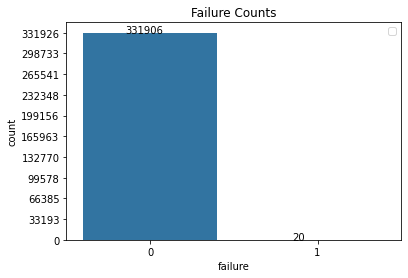

In [43]:
# Checking the balance of the Train Dataset.
total = len(Train)
print(Train.failure.value_counts())
ax = sns.countplot(x = 'failure', data = Train)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.legend()
plt.title("Failure Counts")
plt.show()

0    221397
1         5
Name: failure, dtype: int64


No handles with labels found to put in legend.


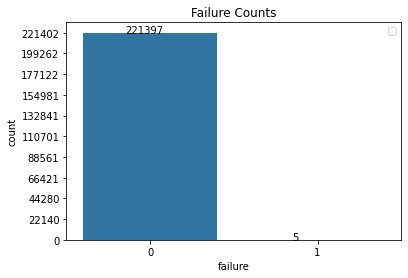

In [44]:
# Checking the balance of the Val Dataset.
total = len(Val)
print(Val.failure.value_counts())
ax = sns.countplot(x = 'failure', data = Val)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.legend()
plt.title("Failure Counts")
plt.show()

From the above, it is found that Dataset is highly imbalanced with class 1 (i.e. HDD is failure) as minority.

In [45]:
#del Data

In [46]:
#Train.drop('smart_241_normalized', axis = 1, inplace = True)
#Val.drop('smart_241_normalized', axis = 1, inplace = True)

# Upsampling of Minority Class of Train using SMOTE





> Instead of upsampling the minority class by normal sampling (i.e. creating duplicates of same points) SMOTE technique is used as upsampling technique as it upsamples by interpolation.

In [47]:
X_Train_orig = Train.drop(f, axis = 1).values
Y_Train_orig = Train.failure.values
X_Val_orig = Val.drop(f, axis = 1).values
Y_Val_orig = Val.failure.values

In [48]:
X_Train_orig.shape, Y_Train_orig.shape

((331926, 52), (331926,))

In [49]:
X_Val_orig.shape, Y_Val_orig.shape

((221402, 52), (221402,))

In [50]:
# Stacking the response encoded array with respective Train and Val dataset.
X_Train_orig = np.hstack((X_Train_orig, Train_model))
X_Val_orig = np.hstack((X_Val_orig, Val_model))
X_Train_orig.shape, X_Val_orig.shape

((331926, 54), (221402, 54))

In [51]:
del Train_model
del Val_model

In [52]:
Counter(Y_Train_orig), Counter(Y_Val_orig)

(Counter({0: 331906, 1: 20}), Counter({0: 221397, 1: 5}))

In [53]:
# SMOTE sampling
# class imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=1, ratio=None)
# k_neighbors (default=5) : number of nearest neighbours to used to construct synthetic samples.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under = RandomUnderSampler(sampling_strategy = 0.8)
over_smote = SMOTE(n_jobs = -1, k_neighbors = 1, sampling_strategy = 0.5)
steps = [('o', over_smote), ('u', under)]
pipeline = Pipeline(steps = steps)

In [54]:
# SMOTE oversampling is applied on Train dataset as per oversampling concepts.
# Since Val dataset is also highly imbalanced, regular oversampling is applied(i.e creating duplicates of minority class)

x_train_sam, y_train_sam = pipeline.fit_resample(X_Train_orig, Y_Train_orig) # Resampling the Training Data by oversampling the minority class using SMOTE 
#and undersampling the majority class.
x_val, y_val = X_Val_orig, Y_Val_orig

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [55]:
x_train_sam.shape, y_train_sam.shape # Final shape of Train datapoints.

((373394, 54), (373394,))

In [56]:
x_val.shape, y_val.shape # Final shape of Val datapoints.

((221402, 54), (221402,))

Counter({0: 207441, 1: 165953})


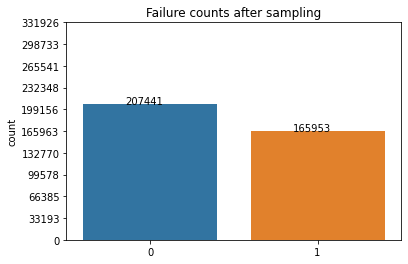

In [57]:
# Visualization after balancing Train Dataset.
total = len(X_Train_orig)
print(Counter(y_train_sam))
ax = sns.countplot(y_train_sam)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.title("Failure counts after sampling")
plt.show()

Counter({0: 221397, 1: 5})


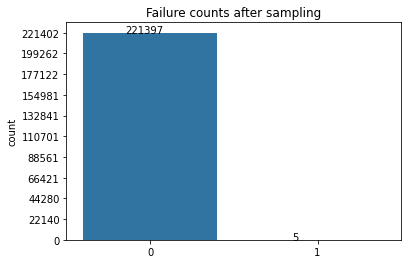

In [58]:
# Visualization after balancing Val Dataset.
total = len(X_Val_orig)
print(Counter(y_val))
ax = sns.countplot(y_val)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.title("Failure counts after sampling")
plt.show()

From the above it is seen that, after oversampling both classes are balanced.

# Standardization:

In [59]:
from sklearn.preprocessing import Normalizer, StandardScaler
normalizer = Normalizer()
sc = StandardScaler()

In [60]:
# Standardizing both Train and Val Dataset.
sc.fit(x_train_sam)

X_train_standard = sc.transform(x_train_sam)
X_val_standard = sc.transform(x_val)

In [61]:
print("Train", np.mean(X_train_standard), np.std(X_train_standard))
print("Val", np.mean(X_val_standard), np.std(X_val_standard))
print(X_train_standard.shape, X_val_standard.shape)

Train 9.757345480049058e-10 1.0000000000001077
Val -0.0945401444922103 1.2401608115054055
(373394, 54) (221402, 54)


In [62]:
X_val_standard[0]

array([ 1.91633772, -0.3588294 , -0.55844467, -0.14182243,  0.01989723,
        0.07941861, -0.0295754 , -0.4389944 , -0.22988139, -0.01316469,
       -1.68425395,  1.60084112, -0.04381009, -0.0111287 ,  0.00968213,
        0.8626936 ,  1.29935999, -0.00471316,  0.49477196, -0.31168971,
        0.41893585, -0.04097912,  0.71540679, -0.28295134, -0.04481608,
       -0.23264227, -1.16643826,  0.78144192, -0.52454634, -1.32890744,
       -1.35503528, -1.1748606 , -0.40766776, -0.01013074, -0.05639001,
       -0.40154648, -0.04431379, -0.40138295,  0.02033544, -0.01797694,
        0.39992646, -0.00340367,  0.41374199,  0.17953259,  0.41374199,
        0.46829818,  0.40284807,  0.40586455,  0.06988634, -2.2112318 ,
        0.40517495,  0.40128917, -0.88996263,  0.88996268])

# Test Dataset

In [63]:
# Creating the Test Dataset to check performance of the model.
# Test data is from 2019-07-06 to 2019-07-07
Test = pd.read_csv("/content/data_Q3_2019/2019-07-06.csv")
Test = Test.append(pd.read_csv("/content/data_Q3_2019/2019-07-07.csv"))

Test.reset_index(inplace = True)
Test.drop('index', axis = 1, inplace = True)
Test.shape

(221277, 129)

In [64]:
Test.failure.value_counts()

0    221271
1         6
Name: failure, dtype: int64

In [65]:
# Preprocessing of Test Data.
Test.drop(Initial[Null], axis = 1, inplace = True)
Test.drop(M_features[index], axis = 1, inplace = True)
Test.shape

(221277, 51)

In [66]:
print(Test.shape)
Test.drop(np.where(Test['capacity_bytes'] == -1)[0], inplace = True)
print(Test.shape)

(221277, 51)
(221277, 51)


In [67]:
Test.failure.value_counts()

0    221271
1         6
Name: failure, dtype: int64

In [68]:
Test = Test.fillna(0)

In [69]:
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   Test[s] = Test[i].apply(Sigmoid)
Test.shape

(221277, 57)

In [70]:
Test_model = res_transform(Test['model'], TR, FA)

In [71]:
X_Test_orig = Test.drop(f, axis = 1).values
Y_Test_orig = Test.failure.values

In [72]:
X_Test_orig = np.hstack((X_Test_orig, Test_model))
X_Test_orig.shape

(221277, 54)

In [73]:
x_test, y_test = X_Test_orig, Y_Test_orig

In [74]:
x_test.shape

(221277, 54)

In [75]:
(Counter(y_test))

Counter({0: 221271, 1: 6})

In [76]:
# Standardisation of Test Dataset.
X_test_standard = sc.transform(x_test)
X_test_standard.shape

(221277, 54)

# Modelling

In [77]:
import warnings
warnings.filterwarnings("ignore")
from random import sample, choice
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report, f1_score, precision_recall_curve
from scipy.stats import randint as sp_randint, uniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC

balance = [{0:1,1:10}, {0:1,1:100}, {0:1,1:1000}, {0:1,1:10000}, {0:10,1:100000}]

In [78]:
# This function is used to plot Cofusion Matrix, Precision Matrix and Recall Matrix.
def plot_matrices(Y, Y_Pred):
    C = confusion_matrix(Y, Y_Pred) # Confusion Matrix
    
    A =(((C.T)/(C.sum(axis=1))).T) # Calculating Recall Matrix
    
    B =(C/C.sum(axis=0)) # Calculating Precision Matrix
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    print("Sum of rows in recall matrix",A.sum(axis=1))
    
    plt.show()


In [79]:
# This function prints the metrics of the model.
def Metrics(model, X, Y, threshold):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    print("The Prescision Score: ", precision_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The Recall Score: ", recall_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The ROC Score: ", roc_auc_score(Y, y_pred_prob))
    print("The F1 Score: ", f1_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print('*'*100)
    print(classification_report(Y, predict_with_best_t(y_pred_prob, threshold)))
    print('*'*100)
    plot_matrices(Y, predict_with_best_t(y_pred_prob, threshold))

In [80]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [81]:
def find_best_threshold(threshould, fpr, tpr):
    # This function finds the optimal threshold value based on G-Mean metric
    # The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.
    # Ref: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    t = threshould[np.argmax(np.sqrt(tpr*(1-fpr)))]
    # sqrt(tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of sqrt(tpr*(1-fpr))", max(np.sqrt(tpr*(1-fpr))), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould): # This function predicts class labels based on the optimal threshold value.
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def BEST(trainscores, testscores, TR, Models): # This function is used to get the best model based on the highest test score.
  ind = np.argmax(testscores)
  test_score = testscores[ind]
  train_score = trainscores[ind]
  threshold = TR[ind]
  best_est = Models[ind]
  return test_score, train_score, threshold, best_est

# LOGISTIC REGRESSION

In [ ]:
# Hyperparameter tuning of Logistic Regression
param = {'C' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],
         'penalty' : ['l1', 'l2', 'elasticnet'],
         'l1_ratio' : list(np.sort(np.random.uniform(0, 1, 10))),
         'class_weight' : balance}
LR = LogisticRegression(n_jobs = -1, solver = 'saga')
param

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0, 100000.0],
 'class_weight': [{0: 1, 1: 10},
  {0: 1, 1: 100},
  {0: 1, 1: 1000},
  {0: 1, 1: 10000},
  {0: 10, 1: 100000}],
 'l1_ratio': [0.12895571484423107,
  0.16267915367959485,
  0.21234233272047942,
  0.23473519319160185,
  0.34290844219298666,
  0.42293543542967293,
  0.5205482478932897,
  0.6072060337465688,
  0.6419166932628214,
  0.6895954288977632],
 'penalty': ['l1', 'l2', 'elasticnet']}

This custom Random SearchCV is built on the original Training dataset with stratifiedkfold split where at each fold the generated training data is sampled and trained with assigned parameter and evaluated on the generated unsampled val data using f1-score metric.

In [ ]:
# Creating custom RandomSearchCV for hyperparameter tuning.
# In this Cross-Validation is done by StratifiedKFold

trainscores = [] # This list is to store the trainscores
testscores  = [] # This list is to store the testscores
Models = [] # This list is to store the models on each iter
TR = []
# This loop is to use ten random values for each hyperparameter
for iter in tqdm(range(0, 10)):
  #print(iter)
  Thresholds = []
  trainscores_folds = []
  testscores_folds  = []
  w = 0
  LR = LogisticRegression(n_jobs = -1, solver = 'saga')
  for key, value in param.items(): # Assigns the value for each hyperparameter
    if isinstance(value, list):
      if (key == 'C'):
        LR.C = value[iter]
      if (key == 'penalty'):
        LR.penalty = choice(value)
      if (key == 'l1_ratio'):
        LR.l1_ratio = value[iter]
      #if (key == 'class_weight'):
       # LR.class_weight = choice(value)
  #print(LR)
  Models.append(LR)
  #print(Models)
  ss = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1) # Splitting the training data into train and val data 
  # using stratifiedKFold (10-folds) to ensure that each fold consists of both classes.
  # Running the loop for each fold
  for train, test in ss.split(X_Train_orig, Y_Train_orig): # This loop uses original training dataset.
      print()
      X_train = np.zeros(len(train))
      Y_train = np.zeros(len(train))
      X_test = np.zeros(len(test))
      Y_test = np.zeros(len(test))

      # selecting the data points based on the train_indices and test_indices
      X_train = X_Train_orig[train]
      Y_train = Y_Train_orig[train]
      X_test  = X_Train_orig[test]
      Y_test  = Y_Train_orig[test]
      print("B", Counter(Y_train)) # Count of training classes before sampling

      X_train, Y_train = pipeline.fit_resample(X_train, Y_train) # Sampling the training data by the above defined pipeline
      print("A", Counter(Y_train)) # Count of training classes after sampling
      # Standardizing the above train and val data.
      sc = StandardScaler()
      sc.fit(X_train)
      X_train = sc.transform(X_train)
      X_test = sc.transform(X_test)

      LR.fit(X_train,Y_train)

      Y_predicted_test = LR.predict_proba(X_test)[:, 1]

      Y_predicted_train = LR.predict_proba(X_train)[:, 1]

      # This following snippets are used tuning the thresholds generated by roc_curve 
      train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, Y_predicted_train)
      test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, Y_predicted_test)
      #thresholds = np.linspace(0.0, 1.0, num=len(te_thresholds))
      best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr) # Finding the best threshold based on the prediction on val data
      Thresholds.append(best_t)

      # F1-score based on the optimal threshold value
      print('Train', f1_score(Y_train, predict_with_best_t(Y_predicted_train, best_t)))
      trainscores_folds.append(f1_score(Y_train, predict_with_best_t(Y_predicted_train, best_t)))

      print('Test', f1_score(Y_test, predict_with_best_t(Y_predicted_test, best_t)))
      testscores_folds.append(f1_score(Y_test, predict_with_best_t(Y_predicted_test, best_t)))

  # print(trainscores_folds)
  TR.append(Thresholds[np.argmax(testscores_folds)]) 
  trainscores.append(np.mean(np.array(trainscores_folds))) # Taking the mean of trainscores obtained from each fold
  testscores.append(np.mean(np.array(testscores_folds))) # Taking the mean of testscores obtained from each fold
  print() 

  0%|          | 0/10 [00:00<?, ?it/s]


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7977326188668996 for threshold 0.228
Train 0.8073635657248663
Test 0.00033131781661558844

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6272559538458617 for threshold 0.305
Train 0.8734355094234917
Test 0.0002826455624646693

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7069576362517569 for threshold 0.957
Train 0.42462764443601175
Test 0.11764705882352941

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9020779843370279 for threshold 0.328
Train 0.8674373641776273
Test 0.0006466214031684449

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7465990498944969 for threshold 0.205
Train 0.778236537874883
Test 0.00027221995372260786

B Counter({0: 298715, 1:

 10%|█         | 1/10 [04:35<41:17, 275.25s/it]

Test 0.19999999999999998


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8292504400773104 for threshold 0.14
Train 0.8347220186485969
Test 0.00038569086876868194

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.688070923388911 for threshold 0.313
Train 0.9558307709454719
Test 0.0011325028312570782

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7069256725290661 for threshold 1.0
Train 0.5175344639492214
Test 0.09999999999999999

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8608742743772373 for threshold 0.146
Train 0.8584877344877344
Test 0.00046527858555309994

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7272609153767842 for threshold 0.07
Train 0.7715589880380055
Test 0.00025575447570332484

B 

 20%|██        | 2/10 [12:46<45:21, 340.15s/it]

Test 0.2857142857142857


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8213468129891146 for threshold 0.089
Train 0.8316415450490832
Test 0.0003702332469455758

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6375465537094422 for threshold 0.134
Train 0.8942102742186564
Test 0.00032195750160978755

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068084598456239 for threshold 1.0
Train 0.5165390110326217
Test 0.06451612903225806

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8924071872245026 for threshold 0.132
Train 0.8866057748268857
Test 0.0005915409642117716

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7733198307322644 for threshold 0.059
Train 0.8004276607546229
Test 0.0002997152704930316

B 

 30%|███       | 3/10 [19:27<41:48, 358.42s/it]

Test 0.19999999999999998


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8194555121091763 for threshold 0.085
Train 0.8308088533873274
Test 0.0003667369579169341

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6373574969764815 for threshold 0.129
Train 0.8943515427339551
Test 0.0003211303789338472

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068937073610667 for threshold 1.0
Train 0.5113180301747747
Test 0.08695652173913042

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8939757000041361 for threshold 0.135
Train 0.8875487191693197
Test 0.0005997900734742841

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7769928412332053 for threshold 0.054
Train 0.8023906736864727
Test 0.0003040206734057916

B 

 40%|████      | 4/10 [26:04<36:58, 369.79s/it]

Test 0.2857142857142857


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8210533044924995 for threshold 0.087
Train 0.8320654702049843
Test 0.00036968576709796677

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6354638361114765 for threshold 0.126
Train 0.8918379898609311
Test 0.00031308703819661864

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068830519838534 for threshold 1.0
Train 0.5014260437186409
Test 0.08333333333333334

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8953900595504886 for threshold 0.142
Train 0.8894525079724616
Test 0.0006074411541381929

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7478288500135957 for threshold 0.054
Train 0.7839850926460553
Test 0.00027335474612177955



 50%|█████     | 5/10 [34:07<33:38, 403.71s/it]

Test 0.2857142857142857


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8167302469144144 for threshold 0.077
Train 0.8284149368387482
Test 0.00036182722749886936

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6366007085870081 for threshold 0.121
Train 0.8935266475027593
Test 0.0003178639542275906

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068084598456239 for threshold 1.0
Train 0.5025689819219791
Test 0.06451612903225806

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8870399122764986 for threshold 0.11
Train 0.8816277621516966
Test 0.0005650515609549371

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7578737169724568 for threshold 0.055
Train 0.7899811703973257
Test 0.00028306560045290494

B 

 60%|██████    | 6/10 [42:09<28:29, 427.44s/it]

Test 0.23529411764705882


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.818535829307111 for threshold 0.079
Train 0.8293533457161341
Test 0.00036506342977092273

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6377355543965288 for threshold 0.129
Train 0.8946848093757301
Test 0.00032278889606197545

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068510848884708 for threshold 1.0
Train 0.5175595607010933
Test 0.07407407407407407

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8959787170845468 for threshold 0.138
Train 0.8892919686035377
Test 0.0006106870229007634

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7810344186002132 for threshold 0.058
Train 0.8045041502604349
Test 0.00030892801977139327



 70%|███████   | 7/10 [48:48<20:56, 418.76s/it]

Test 0.2857142857142857


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8253172142349635 for threshold 0.098
Train 0.8353463294863154
Test 0.00037782185699442716

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6382432164168296 for threshold 0.128
Train 0.8952766903861257
Test 0.00032504469364537625

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068191163473221 for threshold 1.0
Train 0.5071789444255846
Test 0.06666666666666667

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8972724042714589 for threshold 0.155
Train 0.8892774937972678
Test 0.0006179514908079716

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7893608787167903 for threshold 0.06
Train 0.8099203132159677
Test 0.00031964200095892605

B

 80%|████████  | 8/10 [55:28<13:46, 413.16s/it]

Test 0.2857142857142857


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8246415852279416 for threshold 0.085
Train 0.83438499462298
Test 0.0003765060240963855

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6383140208785155 for threshold 0.124
Train 0.8953827154572922
Test 0.0003253619651862697

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7069043625776685 for threshold 1.0
Train 0.5240895155437728
Test 0.09090909090909091

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8941947353005437 for threshold 0.139
Train 0.8876177437835745
Test 0.0006009615384615384

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7389122973711365 for threshold 0.054
Train 0.7792708537142112
Test 0.00026537517415245807

B Co

 90%|█████████ | 9/10 [1:02:11<06:50, 410.23s/it]

Test 0.2857142857142857


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8243492498316052 for threshold 0.089
Train 0.834112397451148
Test 0.00037593984962406017

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.636316680892061 for threshold 0.134
Train 0.8930439228890011
Test 0.00031665611146295124

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068084598456239 for threshold 1.0
Train 0.5183261898273172
Test 0.06451612903225806

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8902269328918535 for threshold 0.121
Train 0.884710510024851
Test 0.0005804672761573065

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7633795487122539 for threshold 0.053
Train 0.7935361842979115
Test 0.00028874611997401286

B C

100%|██████████| 10/10 [1:08:50<00:00, 413.09s/it]

Test 0.2857142857142857



In [ ]:
print(trainscores)
print(testscores)

[0.6686404321323669, 0.6605825045744546, 0.6556846316365179, 0.6590352826897639, 0.6553238658908905, 0.6492714628149225, 0.6793369242942991, 0.660548728652843, 0.6722808476047092, 0.6606324209692415]
[0.08386042672958463, 0.07836670581891136, 0.07190891957591894, 0.08462104658949098, 0.07357940600973836, 0.07560032500198058, 0.08126111009086048, 0.08174113078126642, 0.07756726291475627, 0.0703760715540144]


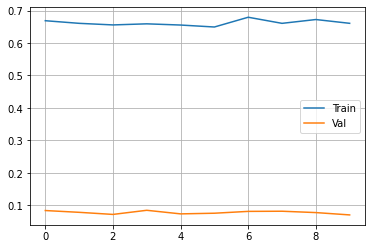

In [ ]:
plt.plot(trainscores,label = "Train")
plt.plot(testscores, label = 'Val')
plt.legend()
plt.grid(True)
plt.show()

This plot shows the trainscores and testscores on each iteration

In [ ]:
# Choosing the best model based on highest test score.
test_score, train_score, threshold, est = BEST(trainscores, testscores, TR, Models)
print(test_score, train_score)

0.08462104658949098 0.6590352826897639


In [ ]:
# Using the best model
LR = est
LR

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.23473519319160185,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Fitting the calibrated classifier over the best model
sig_clf = CalibratedClassifierCV(LR, method="isotonic")
sig_clf.fit(X_train_standard, y_train_sam)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=0.23473519319160185,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=-1,
                                                         penalty='l2',
                                                         random_state=None,
                                                         solver='saga',
                                                         tol=0.0001, verbose=0,
                                  

In [ ]:
Y_predicted_val = sig_clf.predict_proba(X_val_standard)[:, 1]

Y_predicted_train = sig_clf.predict_proba(X_train_standard)[:, 1]

# Threshold Tuning based on the original Val Dataset.
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_sam, Y_predicted_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, Y_predicted_val)
thresholds = np.linspace(0.0, 1.0, num=len(val_thresholds))
best_t = find_best_threshold(val_thresholds, val_fpr, val_tpr)

the maximum value of sqrt(tpr*(1-fpr)) 0.9009816870890021 for threshold 0.084


The Prescision Score:  0.8080380828862819
The Recall Score:  0.9911300187402458
The ROC Score:  0.9928581059739554
The F1 Score:  0.8902678960458338
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    207441
           1       0.81      0.99      0.89    165953

    accuracy                           0.89    373394
   macro avg       0.90      0.90      0.89    373394
weighted avg       0.91      0.89      0.89    373394

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


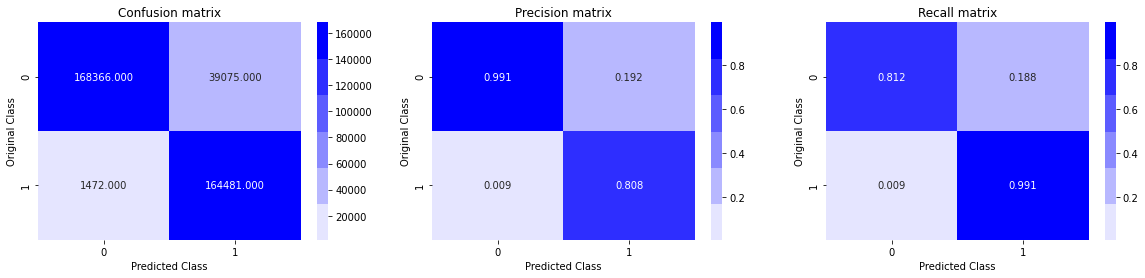

The Prescision Score:  0.0001199644905108088
The Recall Score:  1.0
The ROC Score:  0.9391631322917653
The F1 Score:  0.0002399002015161693
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    221397
           1       0.00      1.00      0.00         5

    accuracy                           0.81    221402
   macro avg       0.50      0.91      0.45    221402
weighted avg       1.00      0.81      0.90    221402

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


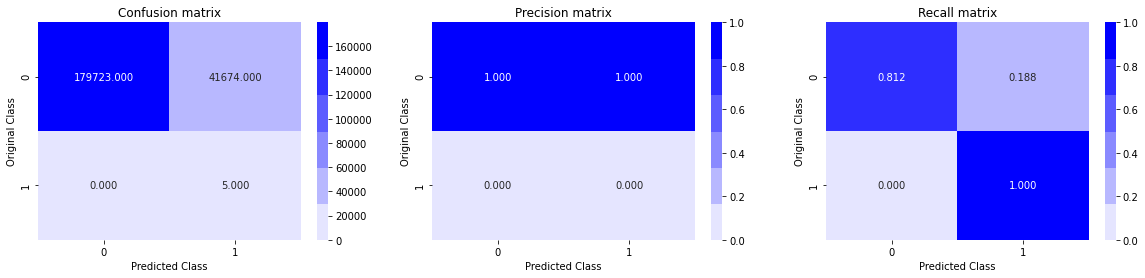

In [ ]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, X_train_standard, y_train_sam, best_t) # Train dataset
print('='*100)
print('='*100)
Metrics(sig_clf, X_val_standard, y_val, best_t) # Val dataset

The Prescision Score:  0.00011943150603129105
The Recall Score:  0.8333333333333334
The ROC Score:  0.8468360065259344
The F1 Score:  0.00023882878364500488
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    221271
           1       0.00      0.83      0.00         6

    accuracy                           0.81    221277
   macro avg       0.50      0.82      0.45    221277
weighted avg       1.00      0.81      0.90    221277

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


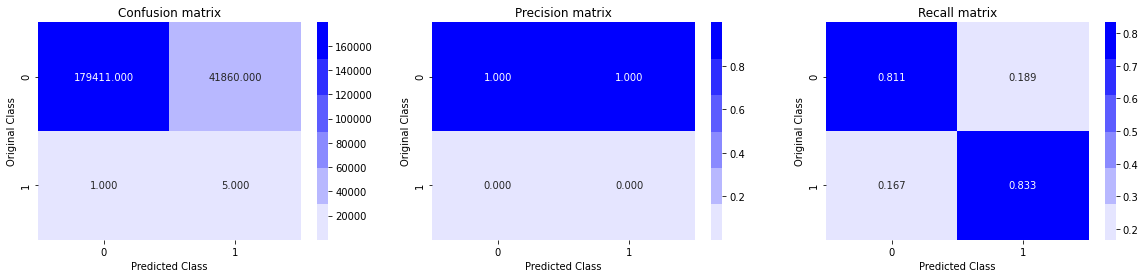

In [ ]:
Metrics(sig_clf, X_test_standard, y_test, best_t) # Test dataset

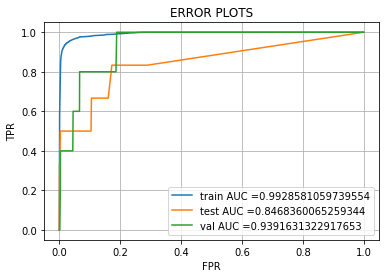

In [ ]:
# Plotting ROC curve for Train, Val and Test.
Y_predicted_test = sig_clf.predict_proba(X_test_standard)[:, 1]

test_fpr, test_tpr, te_thresholds = roc_curve(y_test, Y_predicted_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(val_fpr, val_tpr, label="val AUC ="+str(auc(val_fpr, val_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

This plot shows the roc_curve of train, val and test dataset.

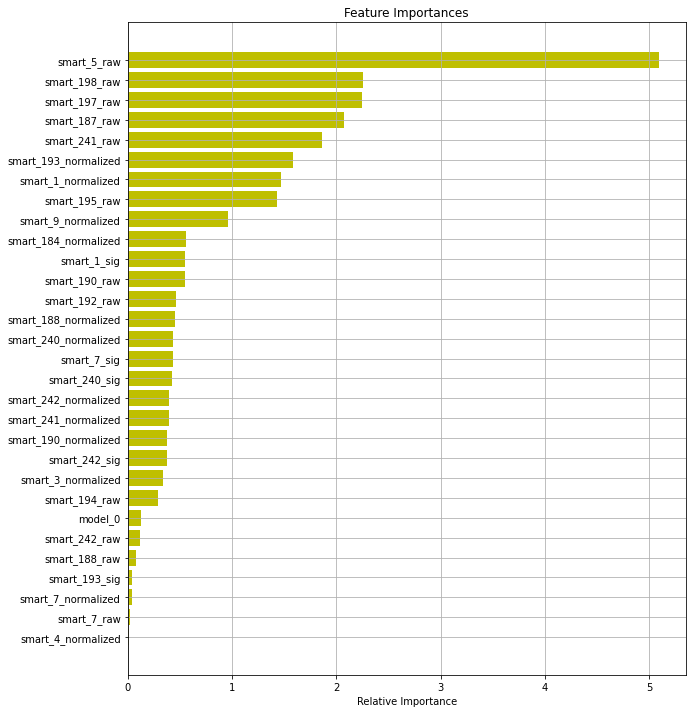

In [ ]:
# FeatureImportances by LR.
LR.fit(X_train_standard, y_train_sam)
features = list(Data.columns)[5:]
features.append('model_1')
features.append('model_0')
importances = LR.coef_[0]
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid(True)
plt.show()

|  Data| Precision  | Recall | ROC-Score | F1-Score |
|------------|--------|----------------------|----------||
|      Train |  0.8080|           0.9911 |  0.9929 | 0.8903|
|    Val   |  0.00012    |  1.0        |   0.9392 |0.00024|
|    Test  |    0.00012  |    0.8333 |   0.8468 |0.00024|

# SVC



> Since Training data is large enough, both libsvm and liblinear solver tends to get hang more time on training the model. Thus, SGD classifier with hinge loss is used as linear SVC.

> As libsvm will take more time on training, kernel SVC are modelled as follows:

1.   Fitting the kernel trick on Training data using sklearn's Nystroem library and then transforming the train, val and test data. This kernel transformation is same as kernel trick done by sklearn svm.
Ref : https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem
2.   Then fitting the linear SVC(SGD classifier) over the transformed Data.







In [ ]:
# Hyperparameter tuning of SGD Classifier and Kernel transformation
param = {'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],
         'penalty' : ['l1', 'l2', 'elasticnet'],
         'l1_ratio' : list(np.sort(np.random.uniform(0, 1, 10))),
         'class_weight' : balance,
         'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
         'degree' : list(np.sort(np.random.randint(1, 7, 10))),
         'gamma' : list(np.sort(np.random.uniform(0, 10, 10))),
         'n_components' : list(30 * np.arange(1, 11))}
svc = SGDClassifier(loss='hinge', n_jobs = -1)
feature_map = Nystroem(random_state=1) # Initialising the kernel transformer.
param

{'alpha': [0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10.0,
  100.0,
  1000.0,
  10000.0,
  100000.0],
 'class_weight': [{0: 1, 1: 10},
  {0: 1, 1: 100},
  {0: 1, 1: 1000},
  {0: 1, 1: 10000},
  {0: 10, 1: 100000}],
 'degree': [2, 2, 2, 4, 4, 4, 4, 5, 6, 6],
 'gamma': [0.18198585960863545,
  2.028100568239166,
  2.448115012424199,
  2.832222833072885,
  4.0831267106432065,
  4.858723672720032,
  7.835489964568306,
  7.891330523094022,
  8.447734692341864,
  9.718487598826487],
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'l1_ratio': [0.12690625775449627,
  0.13547758803355736,
  0.30149311792137545,
  0.3248586076223864,
  0.41548741374306297,
  0.44443520257594904,
  0.5922602464073191,
  0.681195479478065,
  0.854979878656971,
  0.9222253227249064],
 'n_components': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'penalty': ['l1', 'l2', 'elasticnet']}

This custom Random SearchCV is built on the original Training dataset with stratifiedkfold split where at each fold the generated training data is sampled and trained with assigned parameter and evaluated on the generated unsampled val data using f1-score metric.

In [ ]:
# Creating custom RandomSearchCV for hyperparameter tuning.
# In this Cross-Validation is done by StratifiedKFold
trainscores = [] # This list is to store the trainscores
testscores  = [] # This list is to store the testscores
Models = [] # This list is to store the models on each iter
TR = []
F = [] # This list is to store the kernel map on each iter

# This loop is to use ten random values for each hyperparameter
for iter in tqdm(range(0, 10)):
  #print(iter)
  Thresholds = []
  trainscores_folds = []
  testscores_folds  = []
  svc = SGDClassifier(loss='hinge', n_jobs = -1)
  feature_map = Nystroem(random_state=1)
  for key, value in param.items(): # Assigns the value for each hyperparameter
    if isinstance(value, list):
      if (key == 'alpha'):
        svc.C = value[iter]
      if (key == 'penalty'):
        svc.penalty = choice(value)
      if (key == 'l1_ratio'):
        svc.l1_ratio = value[iter]
      if (key == 'kernel'):
        feature_map.kernel = choice(value)
      if (key == 'degree'):
        feature_map.degree = value[iter]
      if (key == 'gamma'):
        feature_map.gamma = value[iter]
      if (key == 'n_components'):
        feature_map.n_components = value[iter]
  Models.append(svc)
  F.append(feature_map)
  ss = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1) # Splitting the training data into train and val data using
  # using stratifiedKFold (10-folds) to ensure that each fold consists of both classes.
  # Running the loop for each fold
  for train, test in ss.split(X_Train_orig, Y_Train_orig): # This loop uses original training dataset.
      print()
      X_train = np.zeros(len(train))
      Y_train = np.zeros(len(train))
      X_test = np.zeros(len(test))
      Y_test = np.zeros(len(test))

      # selecting the data points based on the train_indices and test_indices
      X_train = X_Train_orig[train]
      Y_train = Y_Train_orig[train]
      X_test  = X_Train_orig[test]
      Y_test  = Y_Train_orig[test]
      print("B", Counter(Y_train)) # Count of training classes before sampling

      X_train, Y_train = pipeline.fit_resample(X_train, Y_train) # Sampling the training data by the above defined pipeline
      print("A", Counter(Y_train)) # Count of training classes after sampling
      # Standardizing the above train and val data.
      sc = StandardScaler()
      sc.fit(X_train)
      X_train = sc.transform(X_train)
      X_test = sc.transform(X_test)
      # This code snippet applies the kernel transform on Train and Val data
      X_train = feature_map.fit_transform(X_train)
      X_test = feature_map.transform(X_test)
      # This transformed data is used for the model.

      svc.fit(X_train, Y_train)

      Y_predicted_test = svc.predict(X_test)
      print('Test', f1_score(Y_test, Y_predicted_test))
      testscores_folds.append(f1_score(Y_test, Y_predicted_test))

      Y_predicted_train = svc.predict(X_train)
      print('Train', f1_score(Y_train, Y_predicted_train))
      trainscores_folds.append(f1_score(Y_train, Y_predicted_train))

  trainscores.append(np.mean(np.array(trainscores_folds))) # Taking the mean of trainscores obtained from each fold
  testscores.append(np.mean(np.array(testscores_folds))) # Taking the mean of testscores obtained from each fold
  print() 

  0%|          | 0/10 [00:00<?, ?it/s]


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.005076142131979695
Train 0.9739979946342917

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9770109468441929

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0064516129032258064
Train 0.9737691234998932

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9800781302439221

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9797169875317134

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.003616636528028933
Train 0.9699802750682266

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.010101010101010102
Train 0.9739168697535879

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.977525390116045

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.007194244604316546
Train 0.9778101103292445

B Counter({0: 298716, 1

 10%|█         | 1/10 [00:34<05:06, 34.04s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.005128205128205128
Train 0.9747393867165943

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9769737066002354

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0059701492537313425
Train 0.9736223397578344

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.004454342984409799
Train 0.9802593147162109

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.971306215681669

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.010282776349614397
Train 0.9746716793167275

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.011799410029498525
Train 0.9719289541912882

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.006269592476489028
Train 0.9764062140235397

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.007532956685499058
Train 0.966556

 20%|██        | 2/10 [01:10<04:38, 34.87s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.8518898166810634

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.8562952215497986

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.7909877255793115

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.8205995921731962

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.8511044712001319

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.7965331402831403

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.8463147191699307

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.8133153931946545

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.028169014084507046
Train 0.7560921936049094

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0


 30%|███       | 3/10 [02:09<04:54, 42.10s/it]

Train 0.810802217673827


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.00625
Train 0.9740734201627033

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9783870376529842

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.005917159763313609
Train 0.9749573926684896

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.004555808656036446
Train 0.9806104418749958

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.971308788106312

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.01129943502824859
Train 0.9726557063178728

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.011142061281337047
Train 0.9735037808144859

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.976800918882839

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.006968641114982578
Train 0.968697649283977

 40%|████      | 4/10 [03:10<04:46, 47.79s/it]

Train 0.9728392212235588


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0004443457009553433
Train 0.6547627871249436

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.000245398773006135
Train 0.7242764350799882

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.00018429782528566163
Train 0.6350679912085636

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0005237658766531361
Train 0.7266306578233184

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.7757369517496948

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0005184033177812337
Train 0.737357451828549

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.00033178500331785003
Train 0.7622178258002333

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0003089757454039858
Train 0.7730446327720933

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 

 50%|█████     | 5/10 [1:03:15<1:32:53, 1114.75s/it]

Train 0.7028356906911322


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.8760881505390906

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9080894983443829

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.8829505217778211

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.8525569873062816

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9126390263786176

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9202537773956022

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.8570532219743895

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.8833888980250864

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.8632835093914579

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0


 60%|██████    | 6/10 [1:07:03<56:35, 848.96s/it]   

Train 0.8972654563170579


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.000333889816360601
Train 0.7774102126722057

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0002819681376004511
Train 0.755626946402229

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.00027874564459930314
Train 0.757914174303366

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0003392705682782019
Train 0.7652939446290743

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.7231968875405682

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.00029726516052318666
Train 0.7571360853380007

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0002188902265513845
Train 0.6798333509123511

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.807842930244374

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0005

 70%|███████   | 7/10 [2:29:37<1:44:01, 2080.48s/it]

Train 0.7482118158466706


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9837832389847307

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9755973993076079

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0050251256281407045
Train 0.9751863223816802

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0051813471502590676
Train 0.9879498752225783

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9804237368087658

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.011627906976744186
Train 0.9776408135405368

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.011111111111111112
Train 0.9843845919027987

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.9847567817416323

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.006211180124223603
Train 0.9762611772661

 80%|████████  | 8/10 [2:32:35<50:19, 1509.60s/it]  

Train 0.9748967291934719


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.005449591280653951
Train 0.9727962075651739

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9761375627266898

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.006825938566552901
Train 0.9710976361277847

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.004424778761061947
Train 0.9815094263696909

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9708793280942625

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.010958904109589041
Train 0.9716003056286612

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.011869436201780414
Train 0.9713582396061418

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.9754952987729

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.007905138339920948
Train 0.9

 90%|█████████ | 9/10 [2:33:56<18:00, 1080.95s/it]

Train 0.9723141688309483


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.986529955770004

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9747536779592387

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0058997050147492625
Train 0.980230625844791

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.005221932114882507
Train 0.9857531733090473

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.0
Train 0.9762606975168614

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
Test 0.008714596949891068
Train 0.9741605208417754

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.010869565217391304
Train 0.976389812935451

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.9841905345072958

B Counter({0: 298716, 1: 18})
A Counter({0: 186697, 1: 149358})
Test 0.0
Train 0.9782124820959054

B Counter({0: 29

100%|██████████| 10/10 [2:37:34<00:00, 945.48s/it]

Train 0.9798352015640065



In [ ]:
print(trainscores)
print(testscores)

[0.9765308515722358, 0.9739069335829929, 0.8193934491109964, 0.9743834356988218, 0.7198484980670228, 0.8853569047449789, 0.7505182198564675, 0.980088066634997, 0.9730587477146463, 0.9796316682344376]
[0.004470958491886783, 0.006299812654906578, 0.002816901408450705, 0.005807340435138095, 0.00028114899313827295, 0.0, 0.00022935078147826932, 0.0050361152783195764, 0.0058733222287807784, 0.00400515936894375]


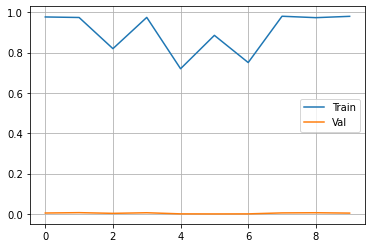

In [ ]:
plt.plot(trainscores,label = "Train")
plt.plot(testscores, label = 'Val')
plt.legend()
plt.grid(True)
plt.show()

This plot shows the trainscores and testscores on each iteration

In [ ]:
TR = list(np.zeros(10))
TR

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
# Choosing the best model based on highest test score.
test_score, train_score, threshold, est = BEST(trainscores, testscores, TR, Models)
print(test_score, train_score)

0.006299812654906578 0.9739069335829929


In [ ]:
# Getting the best kernel map based on highest test score.
f_map = F[testscores.index(0.006299812654906578)]
f_map

Nystroem(coef0=None, degree=2, gamma=2.028100568239166, kernel='linear',
         kernel_params=None, n_components=60, random_state=1)

In [ ]:
# Using the best model
svc = est
svc

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.13547758803355736, learning_rate='optimal',
              loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='l2', power_t=0.5, random_state=None, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Applying the best kernel transform on Train, Original Val and Original Test Datset.
X_TR = f_map.fit_transform(X_train_standard)
X_VA = f_map.transform(X_val_standard)
X_TE = f_map.transform(X_test_standard)

In [ ]:
# Fitting the calibrated classifier over the best model
sig_clf = CalibratedClassifierCV(svc, method="isotonic")
sig_clf.fit(X_TR, y_train_sam)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.13547758803355736,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=-1, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                         

In [ ]:
# Threshold Tuning based on the original Val Dataset.
Y_predicted_val = sig_clf.predict_proba(X_VA)[:, 1]

Y_predicted_train = sig_clf.predict_proba(X_TR)[:, 1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_sam, Y_predicted_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, Y_predicted_val)
thresholds = np.linspace(0.0, 1.0, num=len(val_thresholds))
best_t = find_best_threshold(val_thresholds, val_fpr, val_tpr)

the maximum value of sqrt(tpr*(1-fpr)) 0.8749249457576592 for threshold 0.01


The Prescision Score:  0.7722549270540057
The Recall Score:  0.9999578193825963
The ROC Score:  0.9975112023840568
The F1 Score:  0.8714781613179357
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.76      0.87    207441
           1       0.77      1.00      0.87    165953

    accuracy                           0.87    373394
   macro avg       0.89      0.88      0.87    373394
weighted avg       0.90      0.87      0.87    373394

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


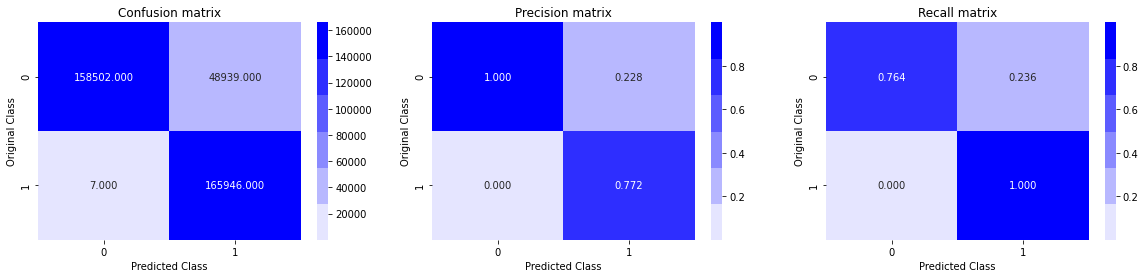

The Prescision Score:  9.629458439257376e-05
The Recall Score:  1.0
The ROC Score:  0.9356748284755438
The F1 Score:  0.00019257062527682026
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    221397
           1       0.00      1.00      0.00         5

    accuracy                           0.77    221402
   macro avg       0.50      0.88      0.43    221402
weighted avg       1.00      0.77      0.87    221402

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


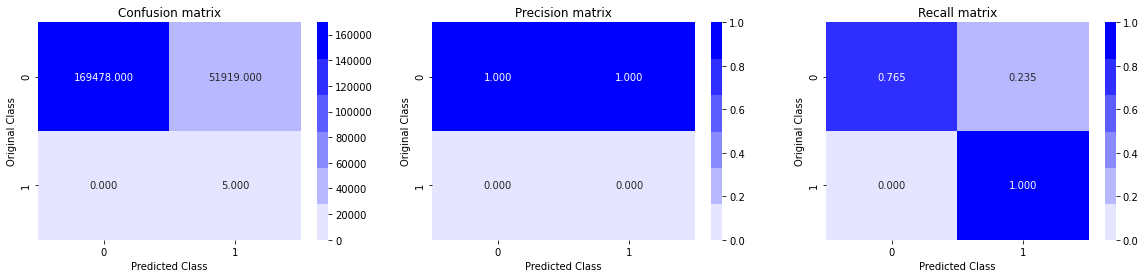

In [ ]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, X_TR, y_train_sam, best_t)
print('='*100)
print('='*100)
Metrics(sig_clf, X_VA, y_val, best_t)

The Prescision Score:  9.681666795755558e-05
The Recall Score:  0.8333333333333334
The ROC Score:  0.9203085055580412
The F1 Score:  0.0001936108422071636
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    221271
           1       0.00      0.83      0.00         6

    accuracy                           0.77    221277
   macro avg       0.50      0.80      0.43    221277
weighted avg       1.00      0.77      0.87    221277

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


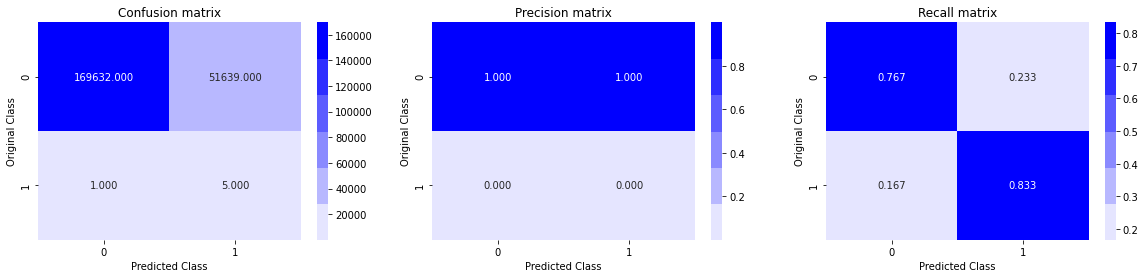

In [ ]:
Metrics(sig_clf, X_TE, y_test, best_t)

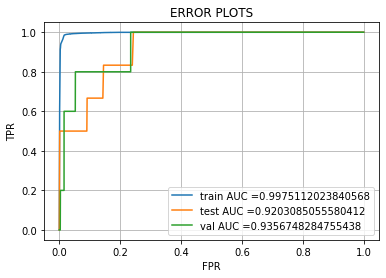

In [ ]:
# Plotting ROC curve for Train, Val and Test.
Y_predicted_test = sig_clf.predict_proba(X_TE)[:, 1]

test_fpr, test_tpr, te_thresholds = roc_curve(y_test, Y_predicted_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(val_fpr, val_tpr, label="val AUC ="+str(auc(val_fpr, val_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

This plot shows the roc_curve of train, val and test dataset.

|  Data| Precision  | Recall | ROC-Score | F1-Score |
|------------|--------|----------------------|----------||
|      Train |  0.7723|           0.9999 |  0.9975 | 0.8714|
|    Val   |  9.629458439257376e-05    | 1.0       |   0.9357 |0.00019|
|    Test  |   9.681666795755558e-05   |    0.8333  |   0.9203 |0.00019|

# STACKING CLASSIFIER







> Estimators : Logistic Regression, SVC

> Meta Classifier : Logistic Regression

In [ ]:
# Hyperparameter tuning of estimators and meta classifier.
param = {'lr__C' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],
         'lr__penalty' : ['l1', 'l2', 'elasticnet'],
         'lr__l1_ratio' : list(np.sort(np.random.uniform(0, 1, 10))),
         'lr__class_weight' : balance,
         'svc__alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],
         'svc__penalty' : ['l1', 'l2'],
         'svc__l1_ratio' : list(np.sort(np.random.uniform(0, 1, 10))),
         'final_estimator__C' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],
         'final_estimator__penalty' : ['l1', 'l2', 'elasticnet'],
         'final_estimator__l1_ratio' : list(np.sort(np.random.uniform(0, 1, 10)))}

svc = SGDClassifier(loss='hinge', n_jobs = -1)
LR = LogisticRegression(n_jobs = -1, solver = 'saga')
meta = LogisticRegression(n_jobs = -1, solver = 'saga')
models = [('lr', LR), ('svc', svc)]
param

{'final_estimator__C': [0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10.0,
  100.0,
  1000.0,
  10000.0,
  100000.0],
 'final_estimator__l1_ratio': [0.10127880332901795,
  0.23315024765732317,
  0.3421894224308154,
  0.4260082517481061,
  0.5110892294515686,
  0.6481890292936432,
  0.7235469620677714,
  0.8737684117365337,
  0.9653528313486653,
  0.9944823502028525],
 'final_estimator__penalty': ['l1', 'l2', 'elasticnet'],
 'lr__C': [0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10.0,
  100.0,
  1000.0,
  10000.0,
  100000.0],
 'lr__class_weight': [{0: 1, 1: 10},
  {0: 1, 1: 100},
  {0: 1, 1: 1000},
  {0: 1, 1: 10000},
  {0: 10, 1: 100000}],
 'lr__l1_ratio': [0.08299431435676596,
  0.15638805507963816,
  0.2423784179307812,
  0.35765795507762566,
  0.40089566960834466,
  0.4503181837728274,
  0.5215238198679176,
  0.5761645933935277,
  0.7859376465592487,
  0.8568246610308674],
 'lr__penalty': ['l1', 'l2', 'elasticnet'],
 'svc__alpha': [0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10.0,
  100.0,
  1000.0

This custom Random SearchCV is built on the original Training dataset with stratifiedkfold split where at each fold the generated training data is sampled and trained with assigned parameter and evaluated on the generated unsampled val data using f1-score metric.

In [ ]:
# Creating custom RandomSearchCV for hyperparameter tuning.
# In this Cross-Validation is done by StratifiedKFold
trainscores = [] # This list is to store the trainscores
testscores  = [] # This list is to store the testscores
Models = [] # This list is to store the models on each iter
TR = []
# This loop is to use ten random values for each hyperparameter
for iter in tqdm(range(0, 10)):
  #print(iter)
  Thresholds = []
  trainscores_folds = []
  testscores_folds  = []
  svc = SGDClassifier(loss='hinge', n_jobs = -1)
  LR = LogisticRegression(n_jobs = -1, solver = 'saga')
  meta = LogisticRegression(n_jobs = -1, solver = 'saga')
  models = [('lr', LR), ('svc', svc)]
  for key, value in param.items(): # Assigns the value for each hyperparameter
    if isinstance(value, list):
      if ('C' in key and 'lr' in key):
        LR.C = value[iter]
      if ('penalty' in key and 'lr' in key):
        LR.penalty = choice(value)
      if ('l1_ratio' in key and 'lr' in key):
        LR.l1_ratio = value[iter]
      
      if ('alpha' in key and 'svc' in key):
        svc.alpha = value[iter]
      if ('penalty' in key and 'svc' in key):
        svc.penalty = choice(value)
      if ('l1_ratio' in key and 'svc' in key):
        svc.l1_ratio = value[iter]

      if ('C' in key and 'final' in key):
        meta.C = value[iter]
      if ('penalty' in key and 'final' in key):
        meta.penalty = choice(value)
      if ('l1_ratio' in key and 'final' in key):
        meta.l1_ratio = value[iter]

  Stack = StackingClassifier(estimators = models, final_estimator = meta, n_jobs = -1)
  #print(Stack)
  Models.append(Stack)
  ss = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1) # Splitting the training data into train and val data
  # using stratifiedKFold (10-folds) to ensure that each fold consists of both classes.
  # Running the loop for each fold
  for train, test in ss.split(X_Train_orig, Y_Train_orig): # This loop uses original training dataset.
      print()
      X_train = np.zeros(len(train))
      Y_train = np.zeros(len(train))
      X_test = np.zeros(len(test))
      Y_test = np.zeros(len(test))

      # selecting the data points based on the train_indices and test_indices
      X_train = X_Train_orig[train]
      Y_train = Y_Train_orig[train]
      X_test  = X_Train_orig[test]
      Y_test  = Y_Train_orig[test]
      print("B", Counter(Y_train)) # Count of training classes before sampling

      X_train, Y_train = pipeline.fit_resample(X_train, Y_train) # Sampling the training data by the above defined pipeline
      print("A", Counter(Y_train)) # Count of training classes after sampling
      # Standardizing the above train and val data.
      sc = StandardScaler()
      sc.fit(X_train)
      X_train = sc.transform(X_train)
      X_test = sc.transform(X_test)
      
      Stack.fit(X_train,Y_train)

      Y_predicted_test = Stack.predict_proba(X_test)[:, 1]
     
      Y_predicted_train = Stack.predict_proba(X_train)[:, 1]
      
      # This following snippets are used tuning the thresholds generated by roc_curve 
      train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, Y_predicted_train)
      test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, Y_predicted_test)
      thresholds = np.linspace(0.0, 1.0, num=len(te_thresholds))
      best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr) # Finding the best threshold based on the prediction on val data
      Thresholds.append(best_t)

      # F1-score based on the optimal threshold value
      print('Test', f1_score(Y_test, predict_with_best_t(Y_predicted_test, best_t)))
      testscores_folds.append(f1_score(Y_test, predict_with_best_t(Y_predicted_test, best_t)))

      print('Train', f1_score(Y_train, predict_with_best_t(Y_predicted_train, best_t)))
      trainscores_folds.append(f1_score(Y_train, predict_with_best_t(Y_predicted_train, best_t))) 
  
  TR.append(Thresholds[np.argmax(testscores_folds)]) 
  trainscores.append(np.mean(np.array(trainscores_folds))) # Taking the mean of trainscores obtained from each fold
  testscores.append(np.mean(np.array(testscores_folds))) # Taking the mean of testscores obtained from each fold
  print() 



  0%|          | 0/10 [00:00<?, ?it/s]


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8597536174551669 for threshold 0.12
Test 0.0004618404341300081
Train 0.8609835195272827

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6900166993659461 for threshold 0.003
Test 0.00022999080036798528
Train 0.7533637489375975

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7069150176336659 for threshold 1.0
Test 0.09523809523809525
Train 0.5942684624355742

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8133663885644266 for threshold 0.074
Test 0.0003559668950787577
Train 0.8253911236619453

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.983871624963707 for threshold 0.172
Test 0.00375234521575985
Train 0.9737037086040142

B Counter({0: 298715, 1: 18})
A



 10%|█         | 1/10 [21:20<3:12:04, 1280.48s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.874055010355765 for threshold 0.077
Test 0.0005103342689461598
Train 0.8734582882540425

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6438244772596056 for threshold 0.001
Test 0.00020579307506302411
Train 0.7329073984110861

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7067232020473166 for threshold 1.0
Test 0.05128205128205129
Train 0.5891098449115127

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8177624964422792 for threshold 0.04
Test 0.00036366942449313574
Train 0.82834372296293

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9513646801317311 for threshold 0.137
Test 0.0012682308180088774
Train 0.9412481592444015

B Counter({0: 298715, 1: 18})



 20%|██        | 2/10 [1:00:44<3:34:03, 1605.45s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.835259842172993 for threshold 0.05
Test 0.00039844606036457814
Train 0.8427630725131614

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.5982585475755617 for threshold 0.033
Test 0.00021197668256491787
Train 0.8502933331815193

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7066059557778173 for threshold 1.0
Test 0.039999999999999994
Train 0.5614718240118454

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8341047718299922 for threshold 0.039
Test 0.00039592200336533703
Train 0.8391243402072571

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9118775098289347 for threshold 0.105
Test 0.0007147962830593281
Train 0.9005766970654956

B Counter({0: 298715, 1: 



 30%|███       | 3/10 [1:41:11<3:36:04, 1852.08s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8219701705565023 for threshold 0.021
Test 0.0003714020427112349
Train 0.8323923959627936

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6218530487056955 for threshold 0.025
Test 0.0002658160552897395
Train 0.8756449040851741

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7069576362517569 for threshold 0.998
Test 0.11764705882352941
Train 0.3457109959700633

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8935374683331617 for threshold 0.031
Test 0.000597460791635549
Train 0.8879821075923767

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8115864289836316 for threshold 0.023
Test 0.00035295155739874706
Train 0.824125011725367

B Counter({0: 298715, 1: 1



 40%|████      | 4/10 [2:21:40<3:22:30, 2025.07s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.821530202549305 for threshold 0.021
Test 0.0003705762460626273
Train 0.832271797700842

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6279880217326821 for threshold 0.02
Test 0.00028510334996436205
Train 0.8836541988616866

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068510848884708 for threshold 0.998
Test 0.07407407407407407
Train 0.5287506765733405

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.897138082054498 for threshold 0.034
Test 0.0006171887054466903
Train 0.8917222955972964

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7922183374855954 for threshold 0.018
Test 0.0003235198964736331
Train 0.811983190262095

B Counter({0: 298715, 1: 18})



 50%|█████     | 5/10 [3:00:50<2:56:52, 2122.44s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8215852114350038 for threshold 0.02
Test 0.0003706792697618385
Train 0.8324179116123405

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6275080736158497 for threshold 0.023
Test 0.00028348688873139615
Train 0.8822422729890573

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7070322126518251 for threshold 0.998
Test 0.2
Train 0.331524530492843

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8937060444064159 for threshold 0.039
Test 0.0005983545250560958
Train 0.8875829699450385

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7920852187126789 for threshold 0.018
Test 0.00032333683614905827
Train 0.811581681446705

B Counter({0: 298715, 1: 18})
A Counter({0



 60%|██████    | 6/10 [3:38:22<2:24:05, 2161.35s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.830666194699387 for threshold 0.027
Test 0.0003886136209074128
Train 0.8395299751834541

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.623631036679957 for threshold 0.019
Test 0.000271112918530568
Train 0.8786946392431872

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7069576362517569 for threshold 0.998
Test 0.11764705882352941
Train 0.4182787960885577

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8890246666675894 for threshold 0.025
Test 0.0005745475438092502
Train 0.8834451266399308

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7581320751155249 for threshold 0.016
Test 0.0002833262501770789
Train 0.7899728137264236

B Counter({0: 298715, 1: 18}



 70%|███████   | 7/10 [4:16:00<1:49:31, 2190.35s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8185910394131358 for threshold 0.019
Test 0.0003651634106262552
Train 0.8301092958435344

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6335288486603452 for threshold 0.024
Test 0.0003052969012364524
Train 0.8894294757465409

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7068937073610667 for threshold 0.998
Test 0.08695652173913042
Train 0.540659276289777

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8910049999384619 for threshold 0.029
Test 0.0005843681519357195
Train 0.8846923906218531

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7945727447916204 for threshold 0.018
Test 0.00032679738562091506
Train 0.8133916050592929

B Counter({0: 298715, 1: 



 80%|████████  | 8/10 [4:54:22<1:14:08, 2224.03s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8253354668023745 for threshold 0.022
Test 0.00037785754770451537
Train 0.8343197414763445

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6321124484216474 for threshold 0.029
Test 0.0002998500749625187
Train 0.8870414600702552

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7067978031832559 for threshold 0.998
Test 0.0625
Train 0.5237578007741528

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8928797175382934 for threshold 0.032
Test 0.000594000594000594
Train 0.887823238058996

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7853813327214698 for threshold 0.016
Test 0.0003144159723313944
Train 0.8077368204728839

B Counter({0: 298715, 1: 18})
A Counter



 90%|█████████ | 9/10 [5:32:24<37:21, 2241.43s/it]  



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8208881598452126 for threshold 0.029
Test 0.0003693785206390248
Train 0.831412388493814

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6319456043871824 for threshold 0.023
Test 0.0002992220227408738
Train 0.8880439274258041

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7069043625776685 for threshold 0.998
Test 0.09090909090909091
Train 0.521006158640647

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8876171359594228 for threshold 0.026
Test 0.0005677785663591199
Train 0.8819661579433762

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7532281165643911 for threshold 0.015
Test 0.000278473962684489
Train 0.7870380616637948

B Counter({0: 298715, 1: 18}



100%|██████████| 10/10 [6:11:03<00:00, 2226.31s/it]

In [ ]:
print(trainscores)
print(testscores)

[0.6692938264035232, 0.6685086957037057, 0.6746404805103391, 0.746327054523317, 0.6638071931909046, 0.7073232602950055, 0.7051252163349851, 0.6653105587272665, 0.6822760250761812, 0.6728948898404608]
[0.09165103623762239, 0.07908733014726098, 0.0715572609039217, 0.045217841201823095, 0.06993933850301216, 0.06788104577366443, 0.05971810124543061, 0.08235396416096794, 0.06881416565626956, 0.08262762634216887]


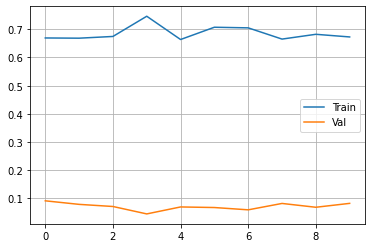

In [ ]:
plt.plot(trainscores,label = "Train")
plt.plot(testscores, label = 'Val')
plt.legend()
plt.grid(True)
plt.show()

This plot shows the trainscores and testscores on each iteration

In [ ]:
# Choosing the best model based on highest test score.
test_score, train_score, threshold, est = BEST(trainscores, testscores, TR, Models)
print(test_score, train_score)

0.09165103623762239 0.6692938264035232


In [ ]:
# Using the best model
Stack = est
Stack

StackingClassifier(cv=None,
                   estimators=[('lr',
                                LogisticRegression(C=0.0001, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=0.08299431435676596,
                                                   max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=-1,
                                                   penalty='elasticnet',
                                                   random_state=None,
                                                   solver='saga', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False)),
               

In [ ]:
# Fitting the calibrated classifier over the best model
sig_clf = CalibratedClassifierCV(Stack, method="isotonic")
sig_clf.fit(X_train_standard, y_train_sam)

CalibratedClassifierCV(base_estimator=StackingClassifier(cv=None,
                                                         estimators=[('lr',
                                                                      LogisticRegression(C=0.0001,
                                                                                         class_weight=None,
                                                                                         dual=False,
                                                                                         fit_intercept=True,
                                                                                         intercept_scaling=1,
                                                                                         l1_ratio=0.08299431435676596,
                                                                                         max_iter=100,
                                                                                         multi_class='auto',


In [ ]:
# Threshold Tuning based on the original Val Dataset.
Y_predicted_val = sig_clf.predict_proba(X_val_standard)[:, 1] #NEW

Y_predicted_train = sig_clf.predict_proba(X_train_standard)[:, 1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_sam, Y_predicted_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, Y_predicted_val)
thresholds = np.linspace(0.0, 1.0, num=len(val_thresholds))
best_t = find_best_threshold(val_thresholds, val_fpr, val_tpr)

the maximum value of sqrt(tpr*(1-fpr)) 0.906882913270706 for threshold 0.014


The Prescision Score:  0.8176214969847464
The Recall Score:  0.9999879483950275
The ROC Score:  0.9979504183927015
The F1 Score:  0.8996560239183998
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    207441
           1       0.82      1.00      0.90    165953

    accuracy                           0.90    373394
   macro avg       0.91      0.91      0.90    373394
weighted avg       0.92      0.90      0.90    373394

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


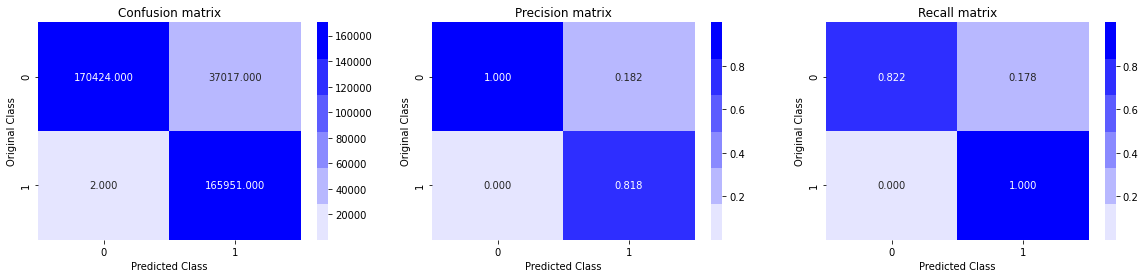

The Prescision Score:  0.00012717145255233106
The Recall Score:  1.0
The ROC Score:  0.9420195395601565
The F1 Score:  0.0002543105640608311
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    221397
           1       0.00      1.00      0.00         5

    accuracy                           0.82    221402
   macro avg       0.50      0.91      0.45    221402
weighted avg       1.00      0.82      0.90    221402

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


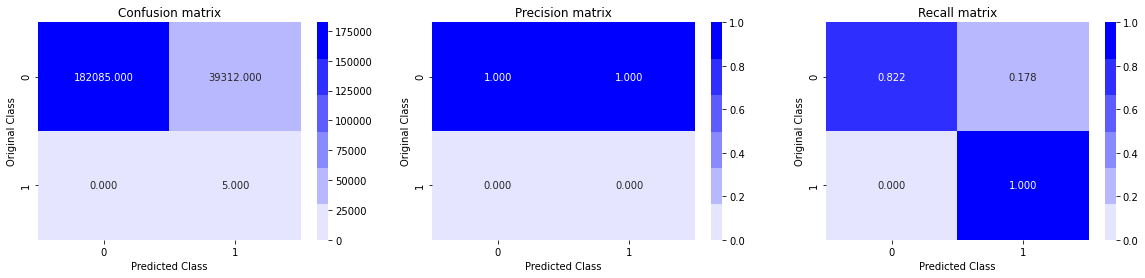

In [ ]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, X_train_standard, y_train_sam, best_t) 
print('='*100)
print('='*100)
Metrics(sig_clf, X_val_standard, y_val, best_t)

The Prescision Score:  0.00012674913810586087
The Recall Score:  0.8333333333333334
The ROC Score:  0.9136496272293553
The F1 Score:  0.0002534597252496578
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    221271
           1       0.00      0.83      0.00         6

    accuracy                           0.82    221277
   macro avg       0.50      0.83      0.45    221277
weighted avg       1.00      0.82      0.90    221277

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


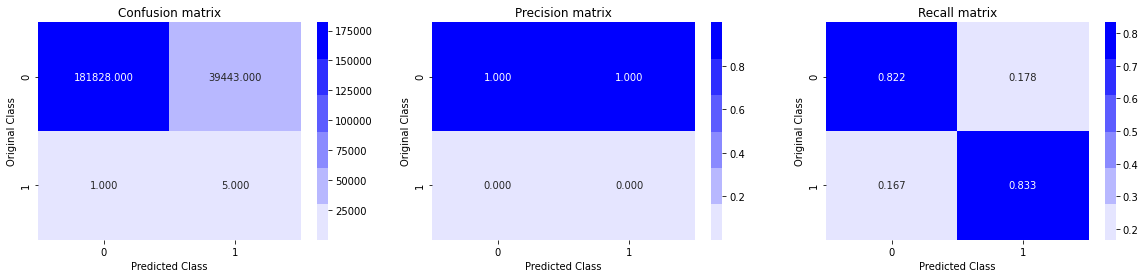

In [ ]:
Metrics(sig_clf, X_test_standard, y_test, best_t) 

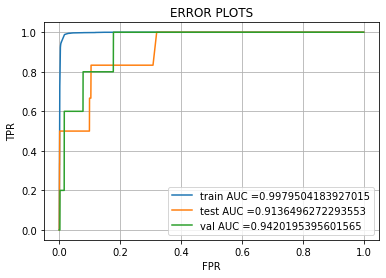

In [ ]:
# Plotting ROC curve for Train, Val and Test.
Y_predicted_test = sig_clf.predict_proba(X_test_standard)[:, 1]

test_fpr, test_tpr, te_thresholds = roc_curve(y_test, Y_predicted_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(val_fpr, val_tpr, label="val AUC ="+str(auc(val_fpr, val_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

This plot shows the roc_curve of train, val and test dataset.

|  Data| Precision  | Recall | ROC-Score | F1-Score |
|------------|--------|----------------------|----------||
|      Train |  0.8176|     0.9999 |  0.9979 | 0.8997|
|    Val   |  0.000127    |  1.0        |   0.9420 |0.00025|
|    Test  |    0.000127  |    0.8333  |   0.9136 |0.00025|

# XGBOOST

In [ ]:
# Hyperparameter tuning of XGBoost
from xgboost import XGBClassifier
param = {'learning_rate' : list(np.sort(np.random.uniform(0, 0.2, 10)))
         'max_depth' : list(np.sort(np.random.randint(10, 100, 10))),
         'colsample_bytree' : list(np.sort(np.random.uniform(0, 1, 10))),
         'subsample' : list(np.sort(np.random.uniform(0, 1, 10))),
         'num_leaves' : list(np.sort(np.random.randint(100, 500, 10))),
         'reg_lambda' : list(np.sort(np.random.uniform(0, 1, 10))),
         'colsample_bylevel' : list(np.sort(np.random.uniform(0, 1, 10))),
         'colsample_bynode' : list(np.sort(np.random.uniform(0, 1, 10))),
         'gamma' : list(np.sort(np.random.uniform(0, 1, 10)))}
GBDT = XGBClassifier(n_jobs = -1, n_estimators = 120)
param

{'colsample_bylevel': [0.023036498567713837,
  0.05504279057928141,
  0.08692831721507133,
  0.44885261998496784,
  0.45216344749346593,
  0.6794584843396948,
  0.683837374173716,
  0.862022113092596,
  0.8806270640121309,
  0.9462807179780963],
 'colsample_bynode': [0.0473354357850414,
  0.18147681452376552,
  0.3235101998272648,
  0.5785378336278127,
  0.6003384237287364,
  0.720471967832248,
  0.8043338493935215,
  0.9010456133438307,
  0.9451386086395991,
  0.9773942741206407],
 'colsample_bytree': [0.23198992143740382,
  0.3014962704516836,
  0.43724731886391444,
  0.5351210531012951,
  0.6819859494561629,
  0.6848651219861739,
  0.7099309515619022,
  0.7136639334665354,
  0.7661012972644032,
  0.9331817851025657],
 'gamma': [0.41258961623026613,
  0.4207432388923745,
  0.5044958250268793,
  0.544334566788759,
  0.5698015861391547,
  0.7425833033812907,
  0.7457414451764884,
  0.8726822205384472,
  0.9729005595982334,
  0.9956501755758013],
 'learning_rate': [0.02376010072360051,


This custom Random SearchCV is built on the original Training dataset with stratifiedkfold split where at each fold the generated training data is sampled and trained with assigned parameter and evaluated on the generated unsampled val data using f1-score metric.

In [ ]:
# Creating custom RandomSearchCV for hyperparameter tuning.
# In this Cross-Validation is done by StratifiedKFold

trainscores = [] # This list is to store the trainscores
testscores  = [] # This list is to store the testscores
Models = [] # This list is to store the models on each iter
TR = []
# This loop is to use ten random values for each hyperparameter
for iter in tqdm(range(0, 10)):
  #print(iter)
  Thresholds = []
  trainscores_folds = []
  testscores_folds  = []
  GBDT = XGBClassifier(n_jobs = -1, n_estimators = 120)
  for key, value in param.items(): # Assigns the value for each hyperparameter
    if isinstance(value, list):
      if (key == "learning_rate"):
        GBDT.learning_rate = value[iter]
      #if (key == "n_estimators"):
        #GBDT.n_estimators = value[iter]
      if (key == "max_depth"):
        GBDT.max_depth = value[iter]
      if (key ==  "colsample_bytree"):
        GBDT.colsample_bytree= value[iter]
      if (key == 'subsample'):
        GBDT.subsample = value[iter]
      if (key == "num_leaves"):
        GBDT.num_leaves = value[iter]
      if (key == "reg_lambda"):
        GBDT.reg_lambda = value[iter]
      if (key == 'colsample_bylevel'):
        GBDT.colsample_bylevel = value[iter]
      if (key == "colsample_bynode"):
        GBDT.colsample_bynode = value[iter]
      if (key == "gamma"):
        GBDT.gamma = value[iter]

  Models.append(GBDT)
  ss = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1) # Splitting the training data into train and val data
  # using stratifiedKFold (10-folds) to ensure that each fold consists of both classes.
  # Running the loop for each fold
  for train, test in ss.split(X_Train_orig, Y_Train_orig): # This loop uses original training dataset.
      print()
      X_train = np.zeros(len(train))
      Y_train = np.zeros(len(train))
      X_test = np.zeros(len(test))
      Y_test = np.zeros(len(test))

      # selecting the data points based on the train_indices and test_indices
      X_train = X_Train_orig[train]
      Y_train = Y_Train_orig[train]
      X_test  = X_Train_orig[test]
      Y_test  = Y_Train_orig[test]
      print("B", Counter(Y_train)) # Count of training classes before sampling

      X_train, Y_train = pipeline.fit_resample(X_train, Y_train) # Sampling the training data by the above defined pipeline
      print("A", Counter(Y_train)) # Count of training classes after sampling
      # Standardizing the above train and val data.
      sc = StandardScaler()
      sc.fit(X_train)
      X_train = sc.transform(X_train)
      X_test = sc.transform(X_test)

      GBDT.fit(X_train,Y_train)

      Y_predicted_test = GBDT.predict_proba(X_test)[:, 1]

      Y_predicted_train = GBDT.predict_proba(X_train)[:, 1]

      # This following snippets are used tuning the thresholds generated by roc_curve 
      train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, Y_predicted_train)
      test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, Y_predicted_test)
      thresholds = np.linspace(0.0, 1.0, num=len(te_thresholds))
      best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr) # Finding the best threshold based on the prediction on val data
      Thresholds.append(best_t)

      # F1-score based on the optimal threshold value
      print('Test', f1_score(Y_test, predict_with_best_t(Y_predicted_test, best_t)))
      testscores_folds.append(f1_score(Y_test, predict_with_best_t(Y_predicted_test, best_t)))

      print('Train', f1_score(Y_train, predict_with_best_t(Y_predicted_train, best_t)))
      trainscores_folds.append(f1_score(Y_train, predict_with_best_t(Y_predicted_train, best_t)))

  TR.append(Thresholds[np.argmax(testscores_folds)])    
  trainscores.append(np.mean(np.array(trainscores_folds))) # Taking the mean of trainscores obtained from each fold
  testscores.append(np.mean(np.array(testscores_folds))) # Taking the mean of testscores obtained from each fold
  print() 




  0%|          | 0/10 [00:00<?, ?it/s]


B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7600768717396759 for threshold 0.166
Test 0.0002853067047075606
Train 0.7928758178608875

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7501418423111137 for threshold 0.16
Test 0.00027552004408320705
Train 0.7853691112828846

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7071067811865476 for threshold 0.77
Test 0.6666666666666666
Train 0.869630038861623

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9971034546766605 for threshold 0.394
Test 0.020408163265306124
Train 0.9965268394238758

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6911292256299394 for threshold 0.151
Test 0.00023066720489014475
Train 0.7535183377351972

B Counter({0: 298715, 1: 18})




 10%|█         | 1/10 [04:30<40:33, 270.40s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7920281609609057 for threshold 0.141
Test 0.000323258445126879
Train 0.8128770664671067

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7936811703997109 for threshold 0.117
Test 0.0003255473264425816
Train 0.8137362532587643

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7071067811865476 for threshold 0.821
Test 0.6666666666666666
Train 0.9252152512674009

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9772193557475658 for threshold 0.27
Test 0.0026684456304202804
Train 0.9730201648369547

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7213959799741544 for threshold 0.103
Test 0.00025122472051249844
Train 0.7688478555746309

B Counter({0: 298715, 1: 18




 20%|██        | 2/10 [08:56<35:53, 269.16s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7817670060272521 for threshold 0.051
Test 0.00030983733539891554
Train 0.8048564276803445

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7257887467659304 for threshold 0.034
Test 0.0002545986888167526
Train 0.7727493791390729

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7070748242060391 for threshold 0.825
Test 0.3333333333333333
Train 0.9985753505475682

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9760779421732014 for threshold 0.143
Test 0.0025429116338207243
Train 0.9714079441167097

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7031437516957634 for threshold 0.036
Test 0.0002383080131069407
Train 0.7594668944721574

B Counter({0: 298715, 1: 




 30%|███       | 3/10 [14:13<33:04, 283.56s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9714523575794178 for threshold 0.0
Test 0.002136752136752137
Train 0.9663023119648304

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7473653925477189 for threshold 0.0
Test 0.0002729257641921397
Train 0.7830520559723599

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7938140215392919 for threshold 0.0
Test 0.0003257328990228013
Train 0.8137417015584862

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7070428657811364 for threshold 0.118
Test 0.22222222222222224
Train 0.9999430907100606

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8368454606963739 for threshold 0.0
Test 0.0004019696512913275
Train 0.8413104337882825

B Counter({0: 298715, 1: 18})
A Co




 40%|████      | 4/10 [25:51<40:47, 407.88s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7800115028789912 for threshold 0.0
Test 0.00030766864087377894
Train 0.8042074203301215

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6973028088678396 for threshold 0.0
Test 0.0021810250817884407
Train 0.9832749057752761

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7955011945830059 for threshold 0.0
Test 0.00032811090148470183
Train 0.8127608630587979

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7070641715582361 for threshold 0.144
Test 0.28571428571428575
Train 0.9999799137630895

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8550977667226672 for threshold 0.0
Test 0.00044812906116961686
Train 0.856657785986114

B Counter({0: 298715, 1: 18})
A




 50%|█████     | 5/10 [38:51<43:17, 519.50s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7066272747283503 for threshold 0.003
Test 0.041666666666666664
Train 0.9992506807431641

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9028792084180045 for threshold 0.0
Test 0.0006516780710329097
Train 0.8980557568177787

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7748183442603771 for threshold 0.0
Test 0.0003014545180495893
Train 0.8011747509018494

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.74655869427976 for threshold 0.0
Test 0.0002721829069134458
Train 0.7829268612316039

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9223571278014009 for threshold 0.0
Test 0.0008067769261799113
Train 0.9154132803785289

B Counter({0: 298715, 1: 18})
A Co




 60%|██████    | 6/10 [57:03<46:04, 691.03s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8625175994272836 for threshold 0.0
Test 0.0004704222039280254
Train 0.8630384347579878

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.6946404705940065 for threshold 0.0
Test 0.001719690455717971
Train 0.9791814859128383

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8089836344474667 for threshold 0.0
Test 0.0003486446439466574
Train 0.822468556576136

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7070428657811364 for threshold 0.078
Test 0.22222222222222224
Train 0.9999631768348816

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9613669678787514 for threshold 0.0
Test 0.0015879317189360857
Train 0.9550413075172007

B Counter({0: 298715, 1: 18})
A Cou




 70%|███████   | 7/10 [1:16:22<41:34, 831.62s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7069256725290661 for threshold 0.011
Test 0.09999999999999999
Train 0.9997456407510291

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.942823244256588 for threshold 0.0
Test 0.001083717149823896
Train 0.9353578116095417

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7883105486641971 for threshold 0.0
Test 0.0003182432970005569
Train 0.8092576688944818

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7070641715582361 for threshold 0.103
Test 0.28571428571428575
Train 0.9999799143010177

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8500797928686579 for threshold 0.0
Test 0.0004343105320304017
Train 0.8535197826155283

B Counter({0: 298715, 1: 18})
A Cou




 80%|████████  | 8/10 [1:39:20<33:10, 995.45s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7145981231007341 for threshold 0.0
Test 0.0002462144527883787
Train 0.7678450706759651

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9322020342724189 for threshold 0.0
Test 0.0009191176470588235
Train 0.9259578425294482

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7071067811865476 for threshold 0.907
Test 0.6666666666666666
Train 0.9999598261812777

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7685715964150276 for threshold 0.0
Test 0.0002943557288983737
Train 0.7947945657437513

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9667578967601705 for threshold 0.0
Test 0.0018399264029438822
Train 0.960878292309474

B Counter({0: 298715, 1: 18})
A Cou




 90%|█████████ | 9/10 [2:06:11<19:40, 1180.02s/it]



B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8592453385946289 for threshold 0.0
Test 0.00046029919447640975
Train 0.8606736393234794

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7688263596269762 for threshold 0.0
Test 0.0002946375957572186
Train 0.797023375944203

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.8284325579963912 for threshold 0.0
Test 0.00038402457757296467
Train 0.8375667680746962

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.7070215593619967 for threshold 0.044
Test 0.1818181818181818
Train 0.9999196620450027

B Counter({0: 298715, 1: 18})
A Counter({0: 186696, 1: 149357})
the maximum value of sqrt(tpr*(1-fpr)) 0.9040963756120283 for threshold 0.0
Test 0.0006595218466611706
Train 0.8975080071869386

B Counter({0: 298715, 1: 18})
A C




100%|██████████| 10/10 [2:41:10<00:00, 967.01s/it] 

In [ ]:
print(trainscores)
print(testscores)

[0.8772526233197008, 0.8957868291076849, 0.8985745198233159, 0.9158872435634942, 0.9212129123039606, 0.9094299853492673, 0.9586088996224152, 0.9244167839574834, 0.919632439904641, 0.929591725048027]
[0.11257670855379476, 0.11572100973669794, 0.06162950013460089, 0.03788327370602689, 0.03949827974531973, 0.013830729363446873, 0.06736773783352532, 0.048315288736516845, 0.0757834703178539, 0.04634456526315029]


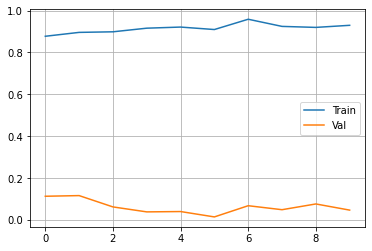

In [ ]:
plt.plot(trainscores,label = "Train")
plt.plot(testscores, label = 'Val')
plt.legend()
plt.grid(True)
plt.show()

This plot shows the trainscores and testscores on each iteration

In [ ]:
# Choosing the best model based on highest test score.
test_score, train_score, threshold, est = BEST(trainscores, testscores, TR, Models)
print(test_score, train_score)

0.11572100973669794 0.8957868291076849


In [ ]:
# Using the best model
GBDT = est
GBDT

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.05504279057928141,
              colsample_bynode=0.18147681452376552,
              colsample_bytree=0.3014962704516836, gamma=0.4207432388923745,
              learning_rate=0.032687274264749044, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=None, n_estimators=120,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=0.2775216435942044,
              scale_pos_weight=1, seed=None, silent=None,
              subsample=0.03102379916474196, verbosity=1)

In [ ]:
# Fitting the calibrated classifier over the best model
sig_clf = CalibratedClassifierCV(GBDT, method="isotonic")
sig_clf.fit(X_train_standard, y_train_sam)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=0.05504279057928141,
                                                    colsample_bynode=0.18147681452376552,
                                                    colsample_bytree=0.3014962704516836,
                                                    gamma=0.4207432388923745,
                                                    learning_rate=0.032687274264749044,
                                                    max_delta_step=0,
                                                    max_depth=15,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=120, n_jobs=-1,
                                                    nthread=None,
     

In [ ]:
# Threshold Tuning based on the original Val Dataset.
Y_predicted_val = sig_clf.predict_proba(X_val_standard)[:, 1]

Y_predicted_train = sig_clf.predict_proba(X_train_standard)[:, 1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_sam, Y_predicted_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, Y_predicted_val)
thresholds = np.linspace(0.0, 1.0, num=len(val_thresholds))
best_t = find_best_threshold(val_thresholds, val_fpr, val_tpr)

the maximum value of sqrt(tpr*(1-fpr)) 0.8423065088948739 for threshold 0.0


The Prescision Score:  0.8771096182205472
The Recall Score:  0.9999397419751376
The ROC Score:  0.9999349781748063
The F1 Score:  0.934505808878602
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    207441
           1       0.88      1.00      0.93    165953

    accuracy                           0.94    373394
   macro avg       0.94      0.94      0.94    373394
weighted avg       0.95      0.94      0.94    373394

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


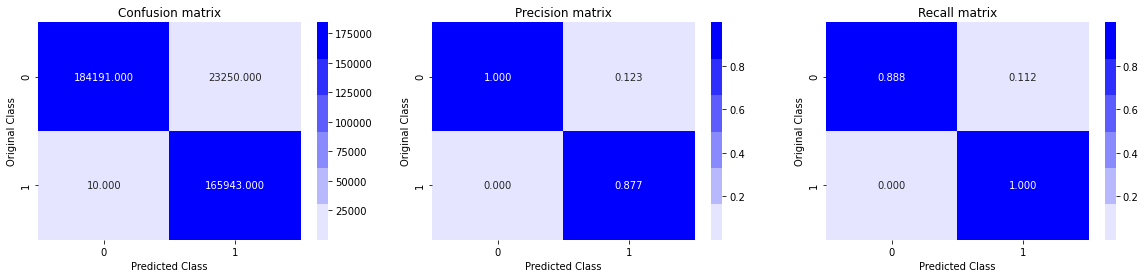

The Prescision Score:  0.00015964877270005986
The Recall Score:  0.8
The ROC Score:  0.8993306142359653
The F1 Score:  0.0003192338387869114
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    221397
           1       0.00      0.80      0.00         5

    accuracy                           0.89    221402
   macro avg       0.50      0.84      0.47    221402
weighted avg       1.00      0.89      0.94    221402

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


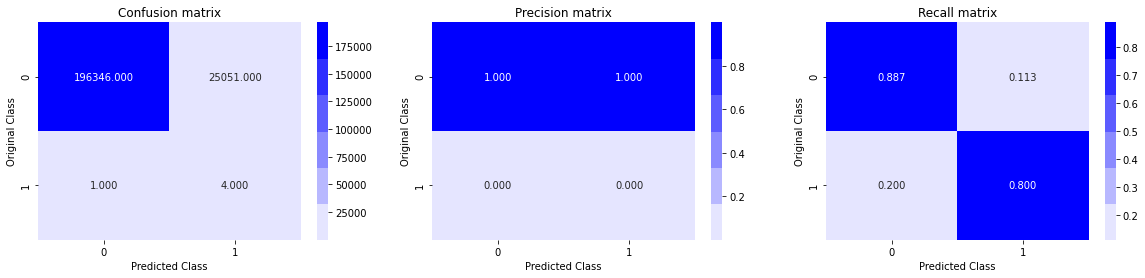

In [ ]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, X_train_standard, y_train_sam, best_t)
print('='*100)
print('='*100)
Metrics(sig_clf, X_val_standard, y_val, best_t)

The Prescision Score:  0.0001203031639732125
The Recall Score:  0.5
The ROC Score:  0.8946194184205492
The F1 Score:  0.00024054845046706487
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    221271
           1       0.00      0.50      0.00         6

    accuracy                           0.89    221277
   macro avg       0.50      0.69      0.47    221277
weighted avg       1.00      0.89      0.94    221277

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


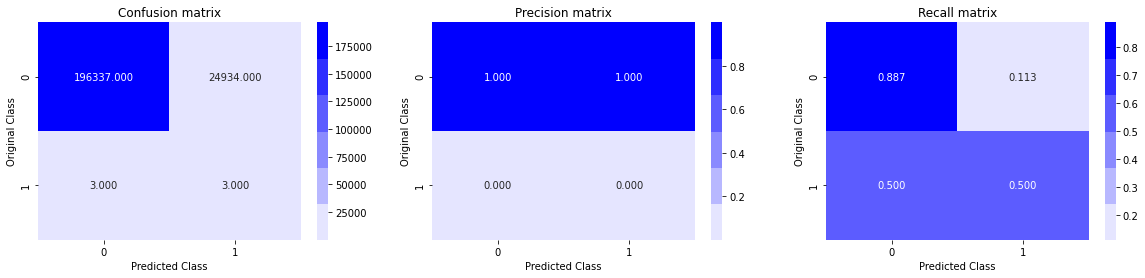

In [ ]:
Metrics(sig_clf, X_test_standard, y_test, best_t)

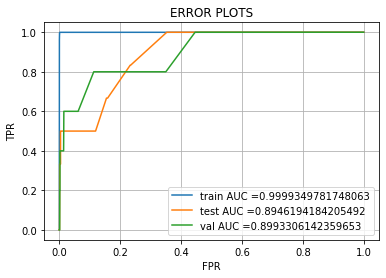

In [ ]:
# Plotting ROC curve for Train, Val and Test.
Y_predicted_test = sig_clf.predict_proba(X_test_standard)[:, 1]

test_fpr, test_tpr, te_thresholds = roc_curve(y_test, Y_predicted_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(val_fpr, val_tpr, label="val AUC ="+str(auc(val_fpr, val_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

This plot shows the roc_curve of train, val and test dataset.

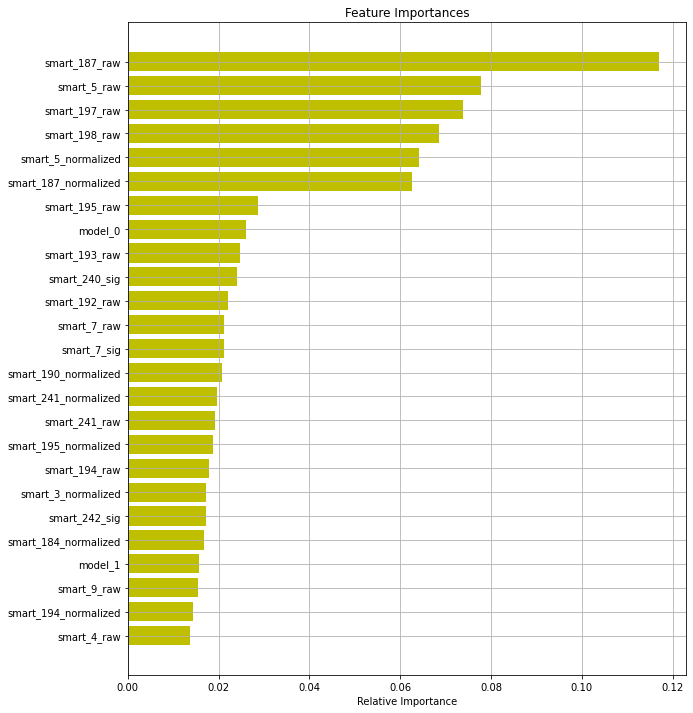

In [ ]:
GBDT.fit(X_train_standard, y_train_sam)
features = list(Data.columns)[5:]
features.append('model_1')
features.append('model_0')
importances = GBDT.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid(True)
plt.show()

|  Data| Precision  | Recall | ROC-Score | F1-Score |
|------------|--------|----------------------|----------||
|      Train |  0.8771|        0.9999 |  0.9999 | 0.9345|
|    Val   |  0.00016    |  0.8        |   0.8993 |0.00032|
|    Test  |    0.00012  |   0.5  |   0.8946 |0.00024|

# Summary

|  Data|Model| Precision  | Recall | ROC-Score | F1-Score |
|------------|----|--------|----------------------|----------||
|      Train |Logistic Reg|  0.8080|   0.9911 |  0.9929 | 0.8903|
|     | SVC|  0.7723    |  0.9999     |   0.9975 |0.8714|
|      |Stacking|    0.8176  |    0.9999  |   0.9979 |0.8997|
|      |GBDT|    0.8771  |    0.9999  |   0.9999 |0.9345|

|  Data|Model| Precision  | Recall | ROC-Score | F1-Score |
|------------|----|--------|----------------------|----------||
|      Val |Logistic Reg|  0.00012    |  1.0    |   0.9392 |0.00024|
|     | SVC|  9.629458439257376e-05    | 1.0       |   0.9357 |0.00019|
|      |Stacking|    0.000127  |    1.0  |   0.9420 |0.00025|
|      |GBDT|    0.00016  |    0.8  |   0.8993 |0.00032|

|  Data|Model| Precision  | Recall | ROC-Score | F1-Score |
|------------|----|--------|----------------------|----------||
|      Test |Logistic Reg|  0.00012  |    0.8333 |   0.8468 |0.00024|
|     |SVC| 9.681666795755558e-05   |    0.8333  |   0.9203 |0.00019|
|      |Stacking|    0.000127  |    0.8333  |   0.9136 |0.00025|
|      |GBDT|    0.00012 |    0.5  |   0.8946 |0.00024|



> The above tables show the performance of each models on Train, Val and Test Dataset.

> All these models doesn't show good precision score on Val and Test data but shows good recall score on par with Train recall score.

> Because of that F1-score is very much less than the Train Data.

> Stacking shows good ROC score on Val Data and also on Test Data when compared to other models.

> Logistic Regression shows good ROC score on Val Data but it doesn't achieve same on the Test Data.

> SVC shows good ROC score on Test Data when compared to other models and it also achieved the good score on Val Data.

> XGboost doesn't perform well on Val and Test Data.



















